In [1]:
import scipy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from heapq import heappush, heappop, heapify
sns.set(color_codes=True)
%matplotlib inline


# Simulation Algorithm

In [23]:
### MY TAXI SIMULATION! ###
import numpy as np
import pandas as pd
from heapq import heappush, heappop, heapify  # For Event Queue
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline



class Rider:
    """
    A Rider (Passenger) class
    """

    def __init__(self, rider_id=None, arrival_time=None, patience=20):
        """
        :param start_time (float): global time when passenger entered queue
        :param car_time (float): global time when passenger got into car
        :param patience (float): threshold for waiting for a car before taking an alternative
        :param pay (int): amount paid
        """
        self.rider_id = rider_id  # TODO: probably don't need that
        self.arrival_time = arrival_time
        # rider patience is normalized around 15, but cutoff at 20
        self.patience = min(np.random.normal(15,5), 20)

        # destination is randomly set between NYC boroughs directions
        # roughly by proportions of residents.
        # DESTINATION: to be used later in aggregation and weighting trip times
        self.destination = np.random.choice(a=[1, 2, 3, 4], p=[0.5, 0.2, 0.2, 0.1])


class Taxi:
    """
    A Vehicle class
    """

    def __init__(self, queue_start_time=None):  # taxi_id
        """
        Initializing paramters of a Taxi
        :param arrive_time (float): time arrived at queue
        :param pickup_time (float):
        :param seats (int):
        :param location (int: 0,1): 0 = outside ot LGA / queue, 1= LGA / queue
        """
        # self.id = taxi_id
        # self.max_seats = 1 # num seats it needs to fill before departing
        self.num_riders = 0  # num of current riders
        self.destination = None

        # waiting and costs
        self.queue_start_time = queue_start_time
        self.wage_rate = 30  # drivers wage is 30$ average per hour #VARIABLE
        self.wages_paid = 0  # how much have we paid driver (so far)
        self.earnings = 0  # starts with 0 earnings: money earned from taxi trips
        self.busy = 0  # handle if taxi is busy or not
        self.waiting_time = 0  # queue waiting time we'll pay for
        self.idle_trip_times_total = 0  # idle trip time we'll pay for

    def enter_LGA_queue(self, time):
        self.queue_start_time = time

    def finish_LGA_queue(self, time):
        queue_time = time - self.queue_start_time
        self.waiting_time += queue_time
        return queue_time

    def assign_pickup(self, rider, pickup_time, trip_money=30):
        """
        Assigns a pickup request
        :param rider:
        :param pickup_time:
        :param trip_money:
        :return:
        """
        # check if free
        # from self.busy and by timing of pickups
        if self.busy == 0:  #
            # set pickup
            self.perform_pickup(pickup_time, trip_money)
        else:
            raise StandardError("Taxi is Busy!")  # TODO: Deal with busy cabs

    def perform_pickup(self, pickup_time, trip_money=30):
        """
        Perform pickup
        :param rider:
        :param pickup_time:
        :param trip_money:
        :return:
        """
        self.num_riders += 1  # num of current riders
        self.pickup_time = pickup_time
        # self.riders = [rider] #TODO not sure if useful

        # self.destination = rider.destination
        # if self.destination == None and riders != []:
        #    self.destination = riders[0].destination

        self.earnings += trip_money



class TaxiStand_Controller():
    def __init__(self, n_rider_arrivals=100, n_dropoffs=10, end_time=60,
                 total_taxis=200, strategy=1, queue_min_buffer=3, tolerance_proportion = 0.1,
                 rate_coefficient = 1, trip_price=30, show=True):
        """

        :param n_rider_arrivals (int): Total num rider appearances/requests from LGA per timespan (default: hour)
        :param n_dropoffs (int): Total num random dropoffs at LGA per timespan (default: hour)
        :param end_time (int): total simulation time. default: hour.
        :param total_taxis (int): total number of taxis in our fleet
        :param strategy (int): choose strategy order number to use: 1 or 2
        :param queue_min_buffer: (int/float) for strategy 1: approximate desired avg minutes for taxi to wait in queue,
                                 to be used in calculating ideal number of taxis in queue
        :param tolerance_proportion: (float) for Strategy 1: percent deviation from optimal taxi number to tolerate before
        :param rate_coefficient: (float) for Strategy 2: coefficient to multiply the postulated rate of cars to send, to be optimzed
        :param trip_price: (int) 30$ per hour in the simulated hours
        :param show: (bool) whether or not to print results
        """
        # Time boundary and initialization
        self.time = 0
        self.end_time = end_time

        # Events Distribution Parameters
        # TODO: get these params from NYC TAXI data
        self.n_dropoffs = n_dropoffs
        self.n_rider_arrivals = n_rider_arrivals
        self.times_dropoffs = None
        self.times_arrivals = None
        self.trip_time_mean = 30
        self.trip_time_sd = 15

        # STRATEGIES
        self.strategy = strategy

        # STRATEGY 1 parameters
        # compute optimal queue size
        self.queue_min_buffer = queue_min_buffer
        self.optimal_taxis = self.get_optimal_LGA_queue_size() if self.strategy == 1 else 0
        # set tolerance of how many cars to allow away from optimal
        self.tolerance_to_optimal_taxis = max(1, tolerance_proportion * self.optimal_taxis) if self.strategy == 1 else 0

        # STRATEGY 2 parameters
        self.rate = 0
        self.rate_coefficient = rate_coefficient

        # Setting Event Queue
        self.schedule = []  # Event Queue: heapq with event times as keys and events as values
                            # each event will be stored as this list format: [execution_time, event_function, list_of_arguments]
                            # using heappush(self.schedule,[execution_time,func,[args_list]])
        self.current_event = None  # the event being currently handled

        # Logging events
        self.df = pd.DataFrame()  # df of metrics
        self.show = show

        # LGA Waiting Taxis Queue
        initial_LGA_taxis = self.n_rider_arrivals // 10 # to have enough for the first 6 min
        self.LGA_taxis_queue = [0] * initial_LGA_taxis  # simple list of queue start times for taxis waiting at LGA
        self.LGA_taxis_queue_len_history = [[0.0,initial_LGA_taxis]] # this will be history of: [time, taxi queue length]
        self.on_way_to_LGA = [] # list of arrival times at LGA queue of random dropoffs and cars we send
        self.weight_for_onway = 0.3 # weight coefficient to discount cars on the way to LGA when calculating queue size
        self.MN_taxis = total_taxis - initial_LGA_taxis  # counter of taxis in Manhattan

        # METRICS and SERVICE QUALITY
        self.riders_count = 0
        self.riders_wait_times = []
        self.churned = 0 # riders who left because ride was too har (too long ETA)
        self.pickedup_riders = 0
        self.dropoffs_LGA_occured = 0

        # Payments, costs
        self.driver_queueing_times_at_LGA = []  # times taxis waited queueing in LGA
        self.driving_idle_time_total = 0  # idle trip time we'll pay for
        self.driving_to_pickup_time_total = 0 # time spent driving to pickup
        self.driving_with_riders_time_total = 0 #time spent driving with a rider in the car
        self.trip_price = trip_price # currently, flat fair. later, have variable trip price based on Time of Day, Distance, +1. #TODO
        self.wage_hourly = 30 #flat hourly wage
        self.costs = 0
        self.earnings = 0
        self.score_cost = 0 # COST FUNCTION TO BE EVENTUALLY MINIMIZED


    def draw_ride_times(self,riders_expected=600,n_peaks=5,sd_ratio=0.01,plot=False):
        """
        Draws arrival / dropoff times at LGA per hour
        From a Gaussian Mixture: specifying total riders per hour, number of peaks,
        and SD / scale of spread per peak, this imputes a normal (Gaussian) distribution
        around each peak time and mixes the them together
        :param riders_per_hour: (int) number of riders arriving within the hour
        :param n_peaks: number of distinct large peaks within the hour (corresponding num of flights)
        :param sd_ratio: Standard deviation / scale of variance (spread) around the mean
                         This should be significantly wider for dropoffs
                         because of people's various time planning habits
                         whereas for landings (pickups), people exit more closely together

        :return: The total list of arrival/dropoff times within an hour (from 0-60)
        """

        # divide peak times (n_flights) currently uniformly along the hour
        flights_peaks = np.sort(np.random.uniform(low=0,high=self.end_time,size=n_peaks))
        # how many riders total and per bump
        riders_per_peak = int(riders_expected / n_peaks)
        riders_total = []
        for mu in flights_peaks:
            # generate normal distribution of passengers around that peak.
            # distribution around each peak, remainder out of 60 (forces to be between 0-60)
            rider_partial_dist = np.mod(np.random.normal(loc=mu, scale=sd_ratio*riders_per_peak, size=riders_per_peak),self.end_time) #% 60
            riders_total.extend(rider_partial_dist)

        if plot:
            print "\n\n\nTotal Distribution"
            sns.distplot(riders_total,bins=100,rug=True,kde=True).set_title("Rider arrivals within one hour")

        return riders_total


    def initialize_events(self):
        """
        Initialize all simulation events, schedule them into the Event Queue schedule.
        :return:
        """
        # Get all dropoff times
        # assuming dropoffs have a similar distribution but wider and less spiky
        # using self.end_time//10 as number of peaks, assuming that planes leave on average every 10 min
        self.times_dropoffs = self.draw_ride_times(self.n_dropoffs,n_peaks=self.end_time//10,sd_ratio=0.4)

        # Get all rider arrival times
        self.times_arrivals =  self.draw_ride_times(self.n_rider_arrivals,n_peaks=self.end_time//10,sd_ratio=0.05)

        # schedule all dropoffs into event queue at corresponding times
        for dropoff_time in self.times_dropoffs:
            heappush(self.schedule,[dropoff_time-self.trip_time_mean,self.dropoff_LGA,[]])

        # schedule all rider_arrivals (requests) into event queue at corresponding times
        for arrival_time in self.times_arrivals:
            heappush(self.schedule,[arrival_time,self.rider_arrives,[]])

        if self.LGA_taxis_queue_len_history:
            self.previous_queue_len_history = self.LGA_taxis_queue_len_history
            self.LGA_taxis_queue_len_history = []

        # Strategies:
        # Strategy 1 is handled in-time, only when changing the queue size
        # Strategy 2: send taxis at constant rate - schedule all these events now
        if self.strategy == 2:
            self.strategy2_send_constant_rate()
        
        # Handle nice printed explanations about time
        if self.show: 
            print("Started Planning for this hour in the previous hour and sending cars into LGA since ~30 minutes prior. This shows as negative time for an hour")
            heappush(self.schedule,[0.00,self.announce_start_time,[]])
        
    def announce_start_time(self):
        if self.time == 0 and self.show: print "\n---------SIMULATION OFFICIALLY STARTED: RIDERS START ARRIVING--------\n--time = 0.00--"

    def get_optimal_LGA_queue_size(self):
        """
        One time run function to determine optimal queue size

        :return: (int) optimal number of Taxis to have at LGA queue
        """
        needed_taxis_overall = self.n_rider_arrivals - self.n_dropoffs
        cars_per_minute = needed_taxis_overall/float(self.end_time)
        # Queue_min_buffer: parameter of ideal queue waiting time on average
        self.optimal_taxis = cars_per_minute * self.queue_min_buffer
        return self.optimal_taxis


    def print_schedule(self):
        print("\nEVENT QUEUE SCHEDULE:")
        schedule_copy = [i for i in self.schedule]
        for i in range(len(schedule_copy)):
            time, func, args = heappop(schedule_copy)
            print("     at {:06.3f}  -  {} , args: {}".format(time, func.__name__, args))
        print

    #def get_next_LGA_dropoff_time(self):
    #    return self.time + scipy.random.exponential(self.LGA_dropoffs_rate)

    def get_trip_time(self, mean = self.trip_time_mean, sd = self.trip_time_sd):
        """
        Draw a random trip time.
        #TODO: Base this on actual distribution of trip times.
        :return:
        """
        # TODO: Implement better trip time distribution
        return abs(np.random.normal(mean, sd))  # PARAMETER


    def dropoff_LGA(self):
        """
        Randomly, (with specified frequency), a taxi will have a dropoff at LGA.
        This function schedules the next dropoff to LGA
        """

        # take a car from manhattan, drive it to LGA
        self.MN_taxis -= 1 # remove car from Manhattan
        trip_duration = self.trip_time_mean
        arrival_time_LGA = self.time + trip_duration

        # Record taxi in the "on the way to LGA" queue: push into queue of taxis on the way to LGA (recorded as arrival time)
        heappush(self.on_way_to_LGA ,arrival_time_LGA)

        # PUSH INTO EVENTS QUEUE:  put car into LGA Queue when arriving there
        heappush(self.schedule, [arrival_time_LGA, self.taxi_enters_LGA_queue, [arrival_time_LGA]])

        self.driving_with_riders_time_total  += trip_duration  # record driving time

        if self.show: print("{:06.3f}: LGA DROPOFF scheduled at  {:06.3f}".format(self.time, arrival_time_LGA))
        self.dropoffs_LGA_occured += 1 # document dropoff to be

        return


    def taxi_enters_LGA_queue(self, current_time):
        """
        Taxi enters waiting queue at LGA, records dropoff and queue start time
        """
        if self.on_way_to_LGA:
            popped_time = heappop(self.on_way_to_LGA)
#             # debugging
#             if self.show and abs(popped_time - current_time) > 1.0:
#                 print("****Popped taxi time {:06.3f} arriving to LGA is different than the current time {:06.3f}".format(popped_time, current_time)) # for debugging; solved

#         else:
#             if self.show: print("****NO CARS 'ON THE WAY' TO LGA; but taxi just entered queue") #debugging
        self.LGA_taxis_queue.append(current_time) # insert the CURRENT time it just entered at
        self.record_taxi_queue_size()

        # Adjust queue size: if too large, send someone away
        self.strategy1_adjust_LGA_queue()


    def taxi_enters_MN(self):
        """ Taxi arrives at Manhattan; increasing MN taxis counter"""
        self.MN_taxis += 1

    #def get_next_rider_time(self):
    #    return self.time + scipy.random.exponential(self.rider_arrival_rate)


    def strategy1_adjust_LGA_queue(self):
        """
        Strategy 1:
        Keep an approximate number of cars at the LGA queue,
        As a function of the expected number of riders per hour
        and the expected number of dropoffs per hour

        Checks current number of Taxis in LGA Queue and on the way
        Sends more taxis if number is too low
        :return:
        """
        # only operate if selected strategy is this one
        if self.strategy != 1: return

        # Decision function
        lacking_taxis = self.optimal_taxis - (len(self.LGA_taxis_queue) + self.weight_for_onway*len(self.on_way_to_LGA)) #positive if we have less taxis than needed

        if lacking_taxis > self.tolerance_to_optimal_taxis:
            # if we have too few taxis, Send more in!
            self.send_tx_to_LGA()
            if self.show: print("{:06.3f}: SENDING CAR TO LGA: queue had {} taxis and {} on the way, while optimal is {}".format(
                        self.time, len(self.LGA_taxis_queue),len(self.on_way_to_LGA), round(self.optimal_taxis,2)))

        excess_proportion_allowed = 3 # parameter manually decided upon, to be refined later on
        if lacking_taxis < -self.tolerance_to_optimal_taxis * excess_proportion_allowed :
            # if we have MUCH too many taxis (twice as much buffer, because if they already stay it's better to sit and stay)
            self.send_tx_away_to_MN()

        return


    def strategy2_send_constant_rate(self):
        """
        Strategy 2:
        Send taxis at a constant rate, based on predicted:
        n_arrivals per hour
        :return:
        """
        if self.strategy != 2: return
        needed_taxis = self.n_rider_arrivals - self.n_dropoffs
        self.rate =  self.rate_coefficient * float(self.end_time)/needed_taxis  # TESTING COEFFICIENT to weight rate
        print("\n\n\n~~~~~~SENDING TAXIS EVERY {} MIN CONSTANTLY FOR {} MIN~~~~~~\n\n\n".format(round(self.rate,2),self.end_time))
        # could also do with np.linspace but wanted to use RATE
        taxi_arrival_times = np.arange(start=0,stop=self.end_time,step=self.rate)
        # incorporating uncertainty in "prediction" and translation:
        # assuming same mean trip time for all cars and sending cars same mean time beforehands
        for taxi_arrival_time in taxi_arrival_times:
            # schedule the SENDING of a taxi an expected mean trip_time before when we'd need it
            heappush(self.schedule, [taxi_arrival_time-self.trip_time_mean, self.taxi_enters_LGA_queue, [taxi_arrival_time]])
        return



    def send_tx_to_LGA(self):
        """
        FORCE SEND to go wait at LGA queue
        """

        # take a car from manhattan, drive it to LGA
        self.MN_taxis -= 1 # remove car from Manhattan
        trip_duration = self.get_trip_time()
        arrival_time_LGA = self.time + trip_duration

        # Record arrival time in queue of taxis on the way to LGA
        heappush(self.on_way_to_LGA ,arrival_time_LGA)

        # PUSH INTO EVENTS QUEUE:  put car into LGA Queue when arriving there
        heappush(self.schedule, [arrival_time_LGA, self.taxi_enters_LGA_queue, [arrival_time_LGA]])

        # record idle driving time
        self.driving_idle_time_total += trip_duration

        if self.show: print("{:06.3f}: SENT CAR TO LGA, arriving at  {:06.3f}".format(self.time, arrival_time_LGA))
        return

    def send_tx_away_to_MN(self):
        """
        FORCE SEND AWAY taxi from LGA queue to Manhattan
        """
        time_away_from_LGA = 0

        # 1. try first sending car ON THE WAY to LGA back to MN
        if self.on_way_to_LGA:
            # if there are cars on the way to LGA, send the furthest one back
            # because the Heapq structure doesn't have a direct
            listsorted = sorted(self.on_way_to_LGA)
            arrival_time_at_LGA = listsorted.pop()
            time_away_from_LGA = abs(arrival_time_at_LGA - self.time)
            heapify(listsorted)
            self.on_way_to_LGA = listsorted
            if self.show: print("{:06.3f}: Sending car from On_the_way_to_LGA back to MN, which was planned to arrive at {:06.3f}".format(self.time, arrival_time_at_LGA))


        # 2. If not, remove the last car from LGA queue
        else:
            # pop last taxi in LGA queue
            queue_start_time = self.LGA_taxis_queue.pop(-1)
            # record waiting time in vain :(
            waiting_time = self.time - queue_start_time
            self.driver_queueing_times_at_LGA.append(waiting_time)
            self.record_taxi_queue_size()
            if self.show: print("{:06.3f}: Sending car from LGA_Taxi_Queue back to MN, after it waited for {:06.3f} min".format(self.time, waiting_time))


        # get trip duration back to MN
        trip_duration = abs(self.get_trip_time() - time_away_from_LGA)  # if the car is midway between MN and LGA, trip is shorter

        # schedule arrival to MN
        arrival_time_LGA = self.time + trip_duration
        heappush(self.schedule,[arrival_time_LGA,self.taxi_enters_MN,[]])

        # record (future) idle trip time
        self.driving_idle_time_total += trip_duration

        if self.show: print("{:06.3f}: SENT CAR AWAY FROM LGA QUEUE TO MN, scheduled at {:06.3f}".format(self.time, arrival_time_LGA))

        return


    def record_taxi_queue_size(self):
        """
        Records current Taxi Queue size at LGA in history
        """
        self.LGA_taxis_queue_len_history.append([self.time,len(self.LGA_taxis_queue)])


    def rider_arrives(self):
        """
        Rider requests a Taxi.
        If next taxi is too long for them, they leave.
        If the next taxi time is okay, they wait, and trip details are recorded.
        """

        # New Rider appears and requests a ride
        self.riders_count += 1
        rider = Rider(self.riders_count, self.time, patience=20)
        if self.show: print("{:06.3f}: RIDER {} ARRIVES and requests ride; patience {}".format(self.time, self.riders_count, rider.patience))


        ################## HANDLE RIDE REQUEST:  ##################

        ################## Case 1 : LGA Queue ##################
        # 1. Get a taxi from LGA waiting Taxis queue if possible
        if self.LGA_taxis_queue:

            # If Taxi in LGA queue, it will arrive in 1 minute
            taxi_queue_start_time = self.LGA_taxis_queue.pop(0)  # take the first taxi in line (index 0 in list)
            taxi = Taxi(queue_start_time=taxi_queue_start_time)  # initialize a Taxi

            # Record Taxi waiting time and changes to queue size // I could remove Taxi object here and just use: self.time - taxi_queue_start_time #TODO
            taxi_waited_time = taxi.finish_LGA_queue(self.time)
            self.driver_queueing_times_at_LGA.append(taxi_waited_time)
            self.record_taxi_queue_size()

            taxi_arrival_interval = abs(np.random.normal(1.5, 0.5))  # Taxi will arrive from LGA queue in roughly 1-2 minutes #TODO: what's the actual time from LGA queue

            if self.strategy == 1:
                # STRATEGY 1 : CHECK QUEUE SIZE AND ADJUST TO REMAIN AROUND OPTIMUM
                self.strategy1_adjust_LGA_queue()

            if self.show: print("{:06.3f}: LGA QUEUE TAXI waited for {:06.3f} min in LGA picks up rider {} in {:06.3f} min".format(self.time, taxi_waited_time, self.riders_count, taxi_arrival_interval))

        ################## Case 2 : Call car from Manhatten ##################
        # 2. If there's no taxi in the queue there, call a Taxi from Manhattan
        else:
            # rider requests a taxi and gets the next taxi time
            taxi_arrival_interval = self.get_trip_time()

            if taxi_arrival_interval > rider.patience:
                # if next_taxi_time is too long for the rider's patience, rider leaves, ride dismissed
                self.churned += 1
                if self.show: print("{:06.3f}: rider {} LEFT. waiting {:.2f} min exceeded patience {:.2f} min".format(self.time, self.riders_count, taxi_arrival_interval ,rider.patience))
                # Rider leaves. this ends execution ends. moves to next event.
                return

            else:
                # if the taxi is within rider's patience, assign taxi and record trip
                taxi = Taxi()
                self.MN_taxis -= 1 # reduce counter of taxis in Manhattan, since we've taken out a taxi
                if self.show: print("{:06.3f}: rider {} gets car from Manhattan coming in {:.2f} min, below patience {}".format(self.time, self.riders_count, taxi_arrival_interval ,rider.patience))

        ##################################################

        # Assign pickup
        pickup_time = self.time + taxi_arrival_interval
        taxi.assign_pickup(rider, pickup_time)
        taxi.busy = True

        # PUSH SCHEDULED PICKUP to Event Queue
        # heappush(self.schedule, [pickup_time, taxi.perform_pickup, [pickup_time]])
        if self.show: print("{:06.3f}: scheduled pickup for rider {} at {:06.3f} min".format(self.time, self.riders_count, pickup_time))

        # PUSH arrival to Manhattan to trip_end time
        trip_duration = self.get_trip_time()
        trip_end_time = pickup_time + trip_duration  # rider home trip time as some function of their destination #TODO: reasonable distriubiton
        # example function suggestion: trip_duration*0.5*rider.destination

        heappush(self.schedule, [trip_end_time , self.taxi_enters_MN, [] ])
        if self.show: print("{:06.3f}: trip will end for rider {} after {} at {:06.3f} min".format(self.time, self.riders_count, trip_duration ,trip_end_time))

        # RECORD INFO: Collect waiting times, prices
        self.riders_wait_times.append(taxi_arrival_interval)
        self.driving_to_pickup_time_total += taxi_arrival_interval
        self.driving_with_riders_time_total += trip_duration
        self.pickedup_riders += 1
        self.earnings += self.trip_price # paying the driver / us

    def calc_costs(self):
        """
        This calculates actual "idle" costs - costs of unproductive idle times, discounted by the profits
        :return: costs (float) for the whole simulation
        """
        self.costs = self.wage_hourly * (self.driving_idle_time_total + np.sum(self.driver_queueing_times_at_LGA))/60.0
        #profit = self.earnings - wages
        return self.costs

    def calc_minimization_function(self):
        """
        THIS IS THE COST FUNCTION WE WANT TO OPTIMIZE BY MINIMIZATION:

        This is a weighted function of the costs of paying drivers in idle queueing times, idle driving times,
        *driver minutes are worth $0.5 because we pay them 30$ per 60 min
        Added weight for the rider queueing time
        And adding cost of trip_price for each churned rider (since we lost paying that)
        rider ride minutes are worth $1 because they pay 30$ for 30min average trip time (60$ hourly)
        :return: (float) composite value to minimize
        """
        self.score_cost = (self.driving_idle_time_total + np.sum(self.driver_queueing_times_at_LGA))/2.0 +\
                           np.sum(self.riders_wait_times) + (self.trip_price * self.churned)
        return self.score_cost

    def run_simulation(self):
        """
        Simulates a Taxi Line Requests at an hour with particular parameters.
        Initialized and runs through the simulation.
        This runs through the event schedule and implements the events one by one
        :return:
        """

        # Initialize first events into schedule
        self.initialize_events()

        # RUN THROUGH SIMULATION!
        while self.time < self.end_time:
            # for simulation duration

            # POP FROM SCHEDULE
            time, eventfunc, args = heappop(self.schedule)
            self.current_event = [eventfunc.__name__, args]  # for logging and debugging #TODO: remove if no need
            # STOP if next time is above simulation time
            if time > self.end_time: break
            # ADVANCE TIME TO THAT TIME
            self.time = time

            # EXECUTE EVENT, WHATEVER EVENT IT IS
            if self.show: print("\n{:06.3f}: executing: {}, with args: {}".format(self.time, eventfunc.__name__, args))
            eventfunc(*args)  # EXECUTING EVENT


    def metrics(self):
        """
        Record and print final plots
        """

        metrics = OrderedDict([
            # STRATEGY
            ('strategy', self.strategy),
            ('s1_queue_min_buffer', self.queue_min_buffer),
            ('s1_optimal_taxis_n', self.optimal_taxis),
            ('s1_tolerance', self.tolerance_to_optimal_taxis),
            ('s2_rate_coefficient', self.rate_coefficient),
            ('s2_rate', self.rate),
            # SETTINGS
            ('time', self.time),
            ('riders_initialized', self.n_rider_arrivals),
            ('riders_so_far', self.riders_count),
            ('dropoffs_initialized', self.n_dropoffs),
            ('dropoffs_LGA_occured', self.dropoffs_LGA_occured),
            ('pickedup', self.pickedup_riders),
            ('churned', self.churned),

            ('LGA_tx_queue_mean', np.mean(self.LGA_taxis_queue_len_history)),
            ('LGA_tx_queue_median', np.median(self.LGA_taxis_queue_len_history)),
            ('LGA_tx_queue_std', np.std(self.LGA_taxis_queue_len_history)),
            ('MN_taxis', self.MN_taxis),

            # METRICS and SERVICE QUALITY
            ('riders_waits_mean', np.mean(self.riders_wait_times)),
            ('riders_waits_median', np.median(self.riders_wait_times)),
            ('riders_waits_std', np.std(self.riders_wait_times)),
            ('driver_queueing_mean', np.mean(self.driver_queueing_times_at_LGA)),
            ('driver_queueing_median', np.median(self.driver_queueing_times_at_LGA)),
            ('driver_queueing_std', np.std(self.driver_queueing_times_at_LGA)),
            ('driving_idle_time_total', self.driving_idle_time_total ),
            ('driving_to_pickup_time_total', self.driving_to_pickup_time_total),
            ('driving_with_riders_time_total', self.driving_with_riders_time_total ),

            #self.trip_price, trip_price # currently), flat fair. later), have variable trip price based on Time of Day), Distance), +1. #TODO
            ('costs', self.calc_costs()),
            ('earnings', self.earnings),
            ('profit', self.earnings - self.costs),
            ('score_cost', self.calc_minimization_function()),
            ])
        # Print dictionary in new lines
        if self.show:
            for i in metrics: print i, ": ", metrics[i]
        # log this in DataFrame
        row = pd.DataFrame.from_dict(metrics, orient='index').T
        self.df = self.df.append(row)
        return row


    def plots(self):
        """
        Show final metric plots
        """
        # For title:
        if self.strategy == 1:
            title_context = " | Strategy 1: q_min_buffer={} (opt_taxis={})".format(round(self.queue_min_buffer),round(self.optimal_taxis))
        elif self.strategy == 2:
            title_context = " | Strategy 2: weight={} (rate={})".format(round(self.rate_coefficient,2),round(self.rate,2))
        # PLOTS
        sns.distplot(self.times_arrivals,bins=self.n_rider_arrivals/5,rug=True,kde=True).set_title("Rider arrivals within {} min".format(self.end_time))
        plt.xlim(0,self.end_time) ; plt.show()
        sns.distplot(self.times_dropoffs,bins=self.n_dropoffs/5,rug=True,kde=True).set_title("Dropoffs within {} min".format(self.end_time))
        plt.xlim(0,self.end_time) ; plt.show()

        # PLOT LGA Queue History
        taxi_queue_history = np.array(self.LGA_taxis_queue_len_history).T
        plt.plot(taxi_queue_history[0], taxi_queue_history[1])
        plt.xlabel("Time (Minutes)") ; plt.ylabel("Number of Taxis in Queue at that minute")
        plt.title("Taxis Queue Size in LGA over time" + title_context)
        plt.xlim(0,self.end_time) ; plt.show()

        # Plot waiting times distribution
        sns.distplot(self.riders_wait_times,bins=len(self.riders_wait_times)/5,rug=True,kde=True).set_title("Histogram: Riders Waiting Times" + title_context)
        plt.xlim(0,) ; plt.show()
        sns.distplot(self.driver_queueing_times_at_LGA,bins=len(self.driver_queueing_times_at_LGA)/5,rug=True,kde=True).set_title("Histogram: Taxis LGA Queueing Times" + title_context)
        plt.xlim(0,) ; plt.show()

# sim =  TaxiStand_Controller(n_rider_arrivals=80, n_dropoffs=30, end_time=30)
# sim = TaxiStand_Controller()
# sim.run_simulation()
# print "sim.riders_count: {}, sim.taxis_count: {}, sim.pickedup_riders: {}".format(sim.riders_count, sim.taxis_count, sim.pickedup_riders)
# print "sim.trips: ", sim.trips


## Preliminary Test demonstration

Started Planning for this hour in the previous hour and sending cars into LGA since ~30 minutes prior. This shows as negative time for an hour

-26.889: executing: dropoff_LGA, with args: []
-26.889: LGA DROPOFF scheduled at  08.706

-26.781: executing: dropoff_LGA, with args: []
-26.781: LGA DROPOFF scheduled at  16.963

-26.268: executing: dropoff_LGA, with args: []
-26.268: LGA DROPOFF scheduled at  39.755

-25.750: executing: dropoff_LGA, with args: []
-25.750: LGA DROPOFF scheduled at  -12.573

-23.786: executing: dropoff_LGA, with args: []
-23.786: LGA DROPOFF scheduled at  -10.744

-23.714: executing: dropoff_LGA, with args: []
-23.714: LGA DROPOFF scheduled at  10.110

-23.430: executing: dropoff_LGA, with args: []
-23.430: LGA DROPOFF scheduled at  23.053

-23.211: executing: dropoff_LGA, with args: []
-23.211: LGA DROPOFF scheduled at  -4.530

-22.500: executing: dropoff_LGA, with args: []
-22.500: LGA DROPOFF scheduled at  21.549

-20.243: executing: dropoff_LGA, with args: 

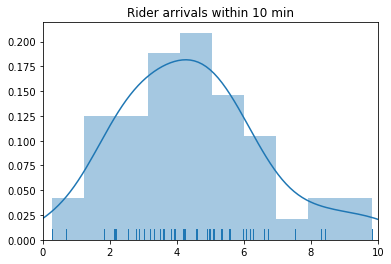

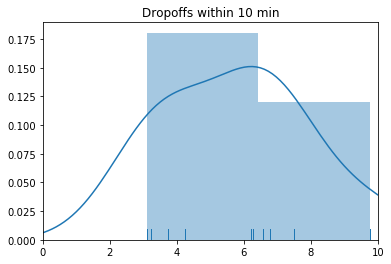

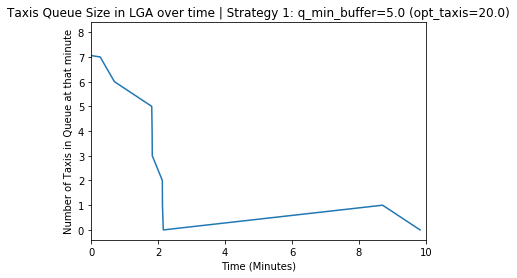

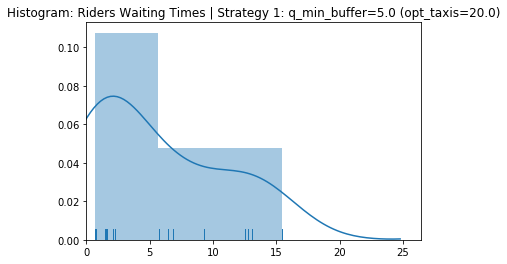

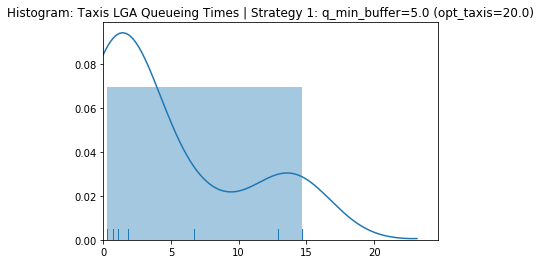

strategy :  1
s1_queue_min_buffer :  5
s1_optimal_taxis_n :  20.0
s1_tolerance :  2.0
s2_rate_coefficient :  1
s2_rate :  0
time :  9.84036420821
riders_initialized :  50
riders_so_far :  50
dropoffs_initialized :  10
dropoffs_LGA_occured :  10
pickedup :  17
churned :  33
LGA_tx_queue_mean :  2.05815035685
LGA_tx_queue_median :  2.0630002543
LGA_tx_queue_std :  5.07785063975
MN_taxis :  14
riders_waits_mean :  5.58919458208
riders_waits_median :  2.2494279497
riders_waits_std :  5.0207865228
driver_queueing_mean :  4.64401900754
driver_queueing_median :  1.82070533211
driver_queueing_std :  5.20820318445
driving_idle_time_total :  450.76203628
driving_to_pickup_time_total :  95.0163078953
driving_with_riders_time_total :  893.895414385
costs :  246.279103674
earnings :  510
profit :  263.720896326
score_cost :  1331.29541157


0
strategy                           1.000000
s1_queue_min_buffer                5.000000
s1_optimal_taxis_n                20.000000
s1_tolerance                       2.000000
s2_rate_coefficient                1.000000
s2_rate                            0.000000
time                               9.840364
riders_initialized                50.000000
riders_so_far                     50.000000
dropoffs_initialized              10.000000
dropoffs_LGA_occured              10.000000
pickedup                          17.000000
churned                           33.000000
LGA_tx_queue_mean                  2.058150
LGA_tx_queue_median                2.063000
LGA_tx_queue_std                   5.077851
MN_taxis                          14.000000
riders_waits_mean                  5.589195
riders_waits_median                2.249428
riders_waits_std                   5.020787
driver_queueing_mean               4.644019
driver_queueing_median             1.820705
driver_queueing_std                5.208203
driving_idle_time_total          450.762036
driving_to_pickup_time_total      95.016308
driving_with_riders_time_total   893.895414
costs                            246.279104
earnings                         510.000000
profit                           263.720896
score_cost                      1331.295412

In [25]:
# Sample case (with relatively fewer rides, for printing)
sim = TaxiStand_Controller(n_rider_arrivals=50, n_dropoffs=10, 
                           end_time=10,total_taxis=50, 
                           strategy=1, queue_min_buffer=5, 
                           tolerance_proportion = 0.1,
                           trip_price=30, show=1)
sim.run_simulation()
sim.plots()
sim.metrics().T

# Testing Simulation with Strategy 1
## Adjusting queue with each taxi leaving to regress to optimal queue size

================ Testing Queueing Minutes Buffer For Strategy 1 ===============

----------SIMULATING STRATEGY 1 WITH BUFFER 4 MIN------------




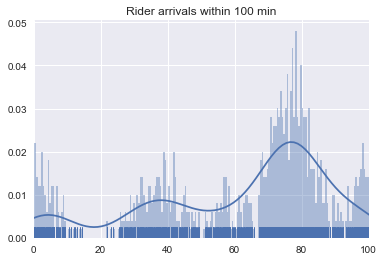

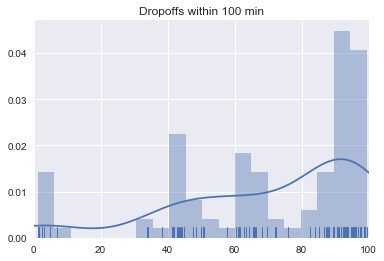

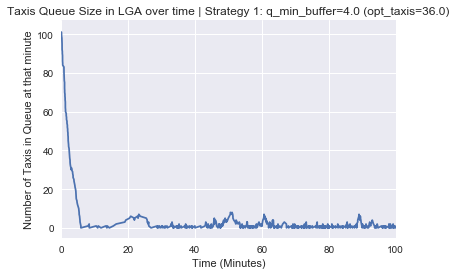

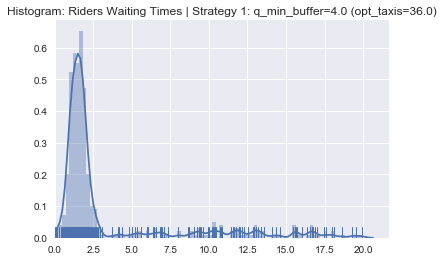

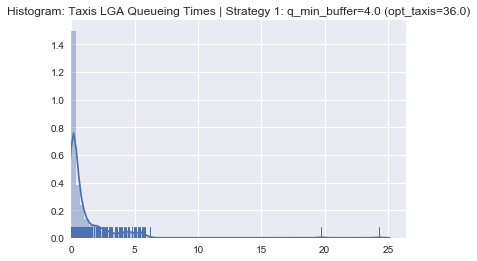


----------SIMULATING STRATEGY 1 WITH BUFFER 5 MIN------------




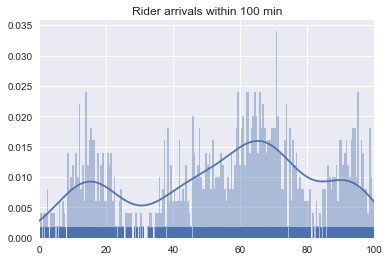

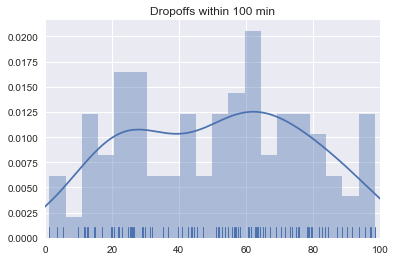

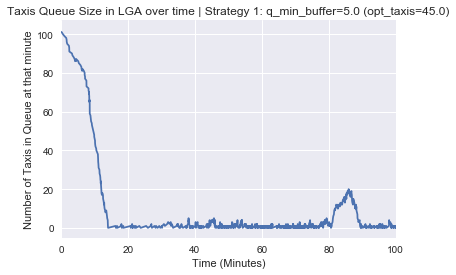

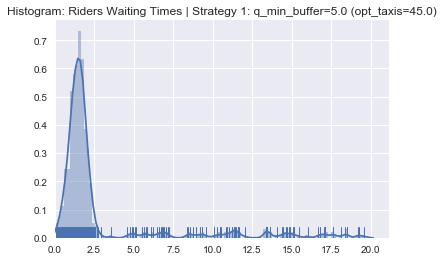

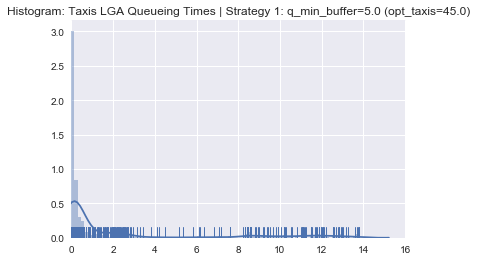


----------SIMULATING STRATEGY 1 WITH BUFFER 6 MIN------------




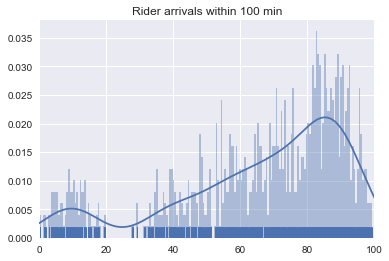

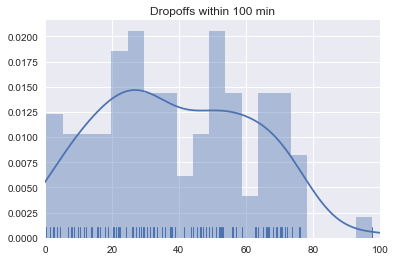

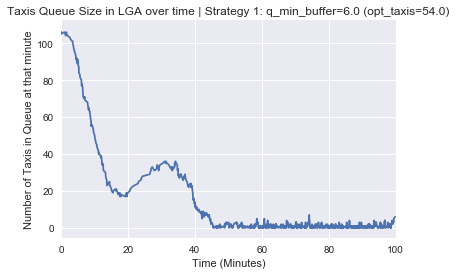

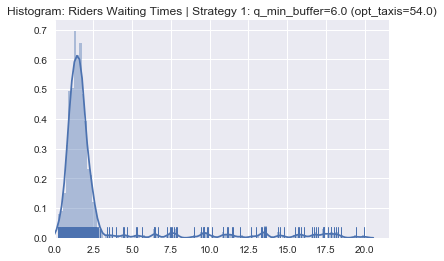

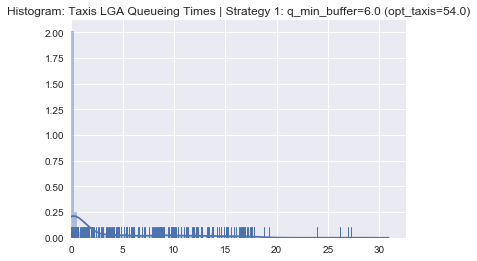


----------SIMULATING STRATEGY 1 WITH BUFFER 7 MIN------------




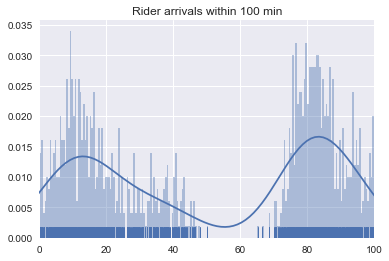

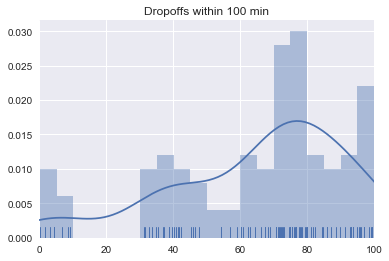

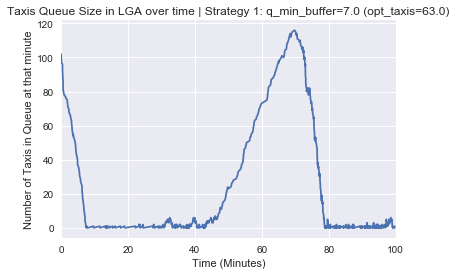

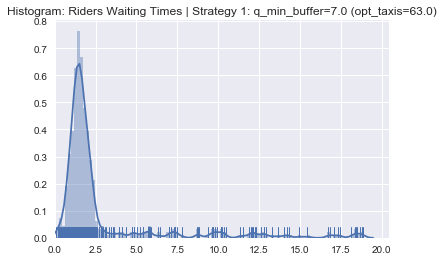

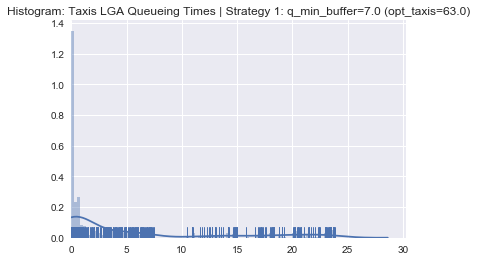


----------SIMULATING STRATEGY 1 WITH BUFFER 8 MIN------------




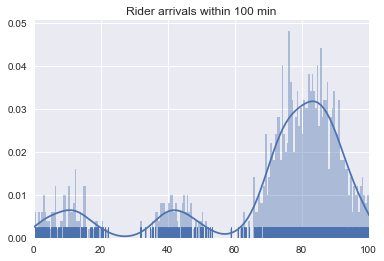

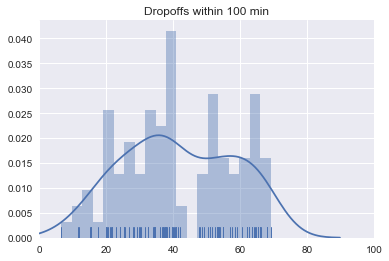

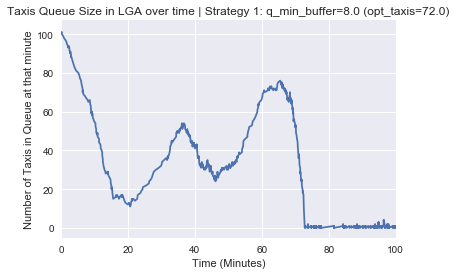

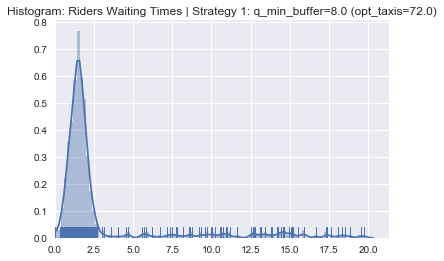

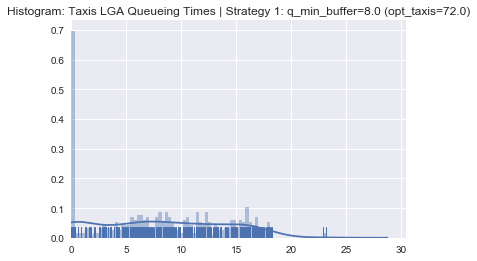


----------SIMULATING STRATEGY 1 WITH BUFFER 9 MIN------------




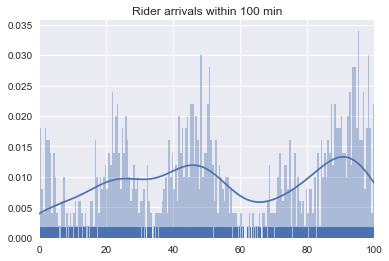

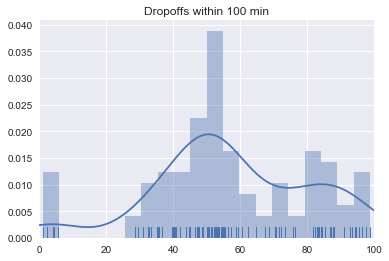

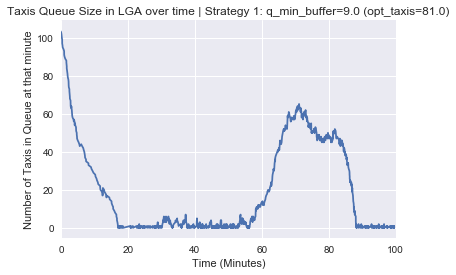

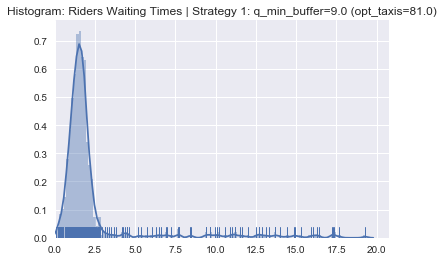

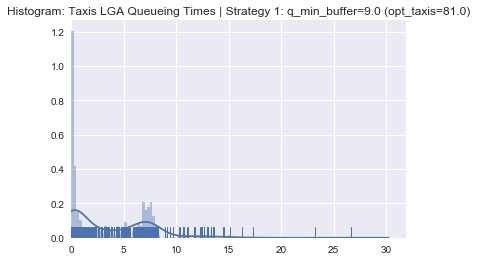


----------SIMULATING STRATEGY 1 WITH BUFFER 10 MIN------------




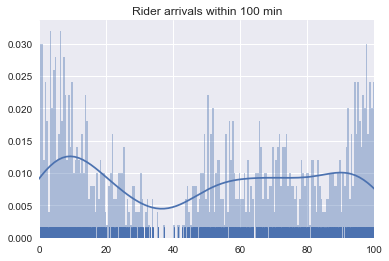

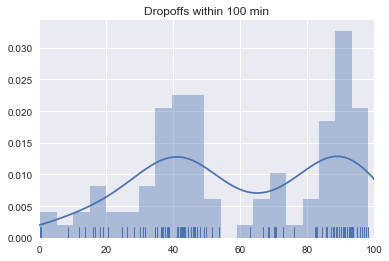

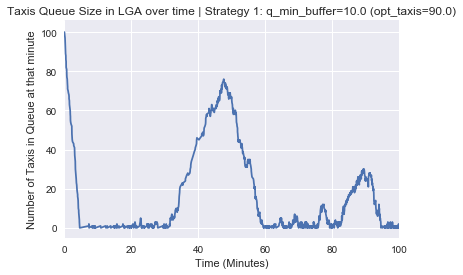

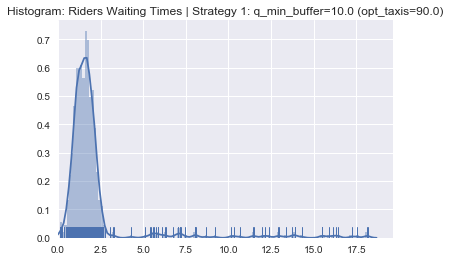

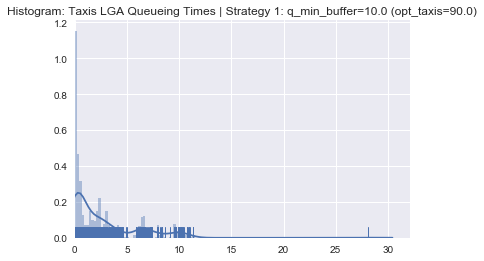


----------SIMULATING STRATEGY 1 WITH BUFFER 11 MIN------------




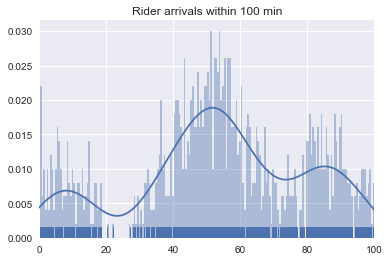

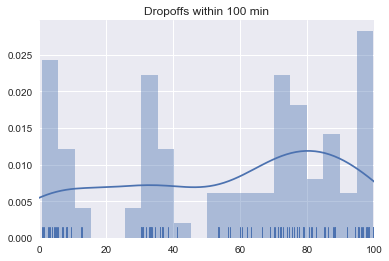

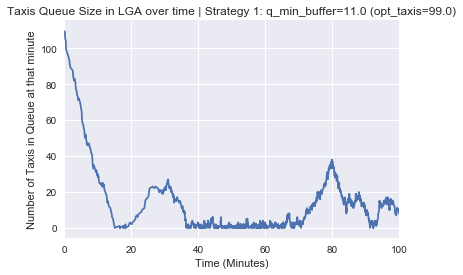

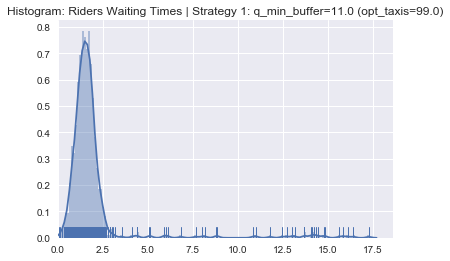

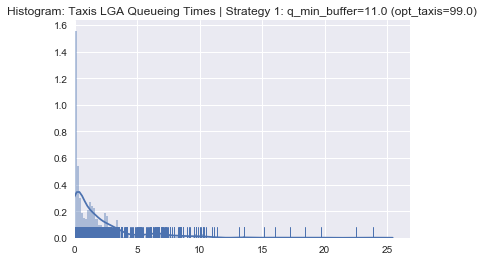


----------SIMULATING STRATEGY 1 WITH BUFFER 12 MIN------------




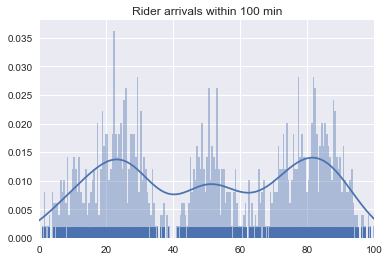

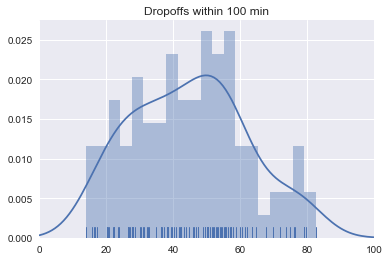

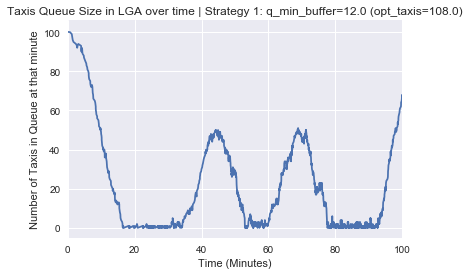

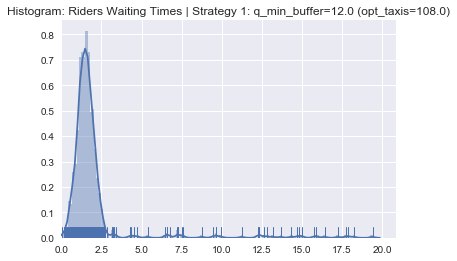

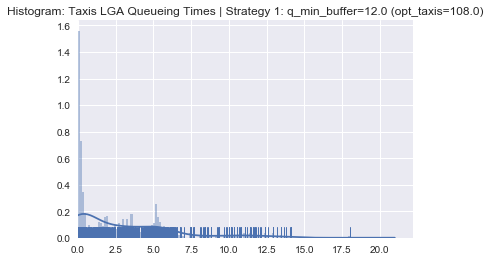


----------SIMULATING STRATEGY 1 WITH BUFFER 13 MIN------------




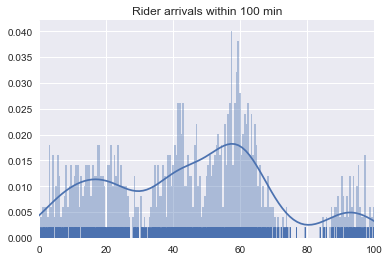

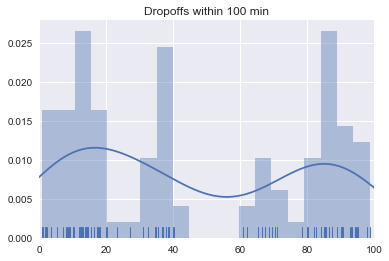

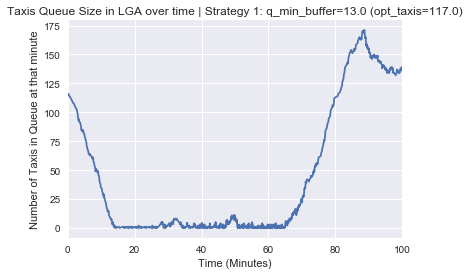

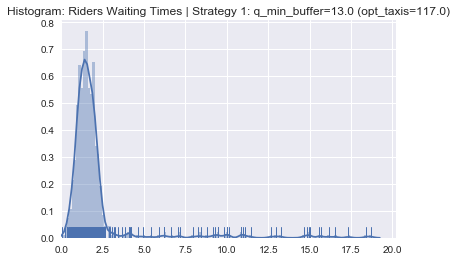

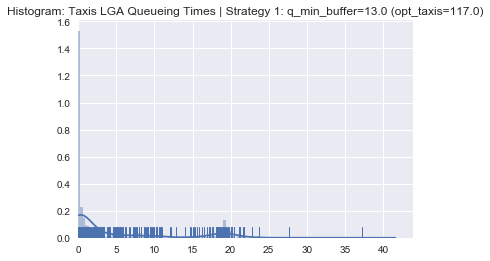


----------SIMULATING STRATEGY 1 WITH BUFFER 14 MIN------------




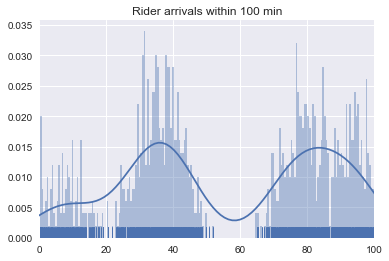

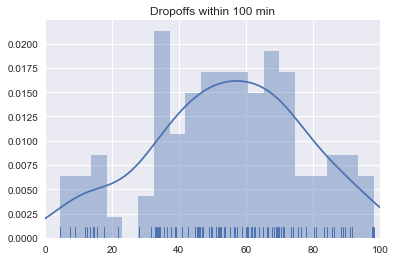

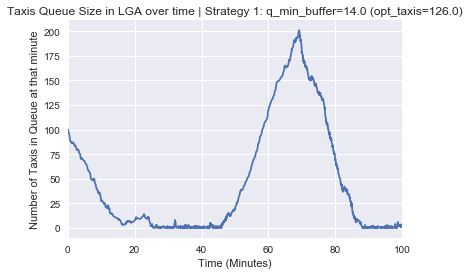

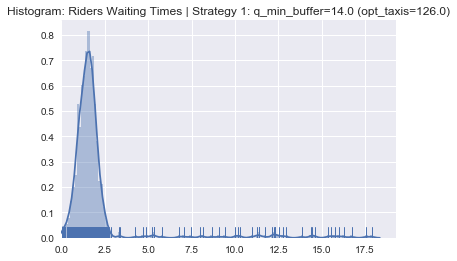

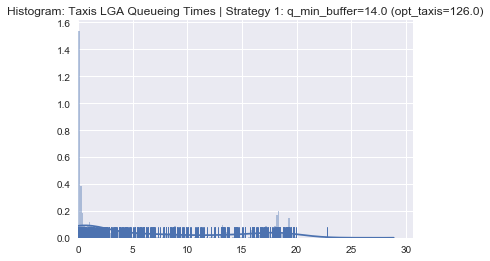


----------SIMULATING STRATEGY 1 WITH BUFFER 15 MIN------------




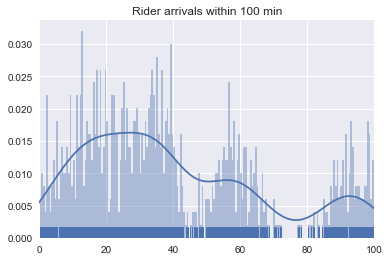

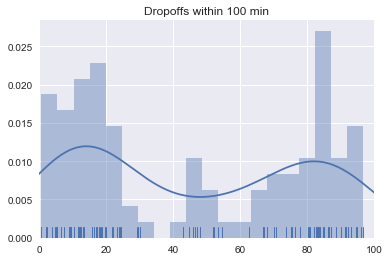

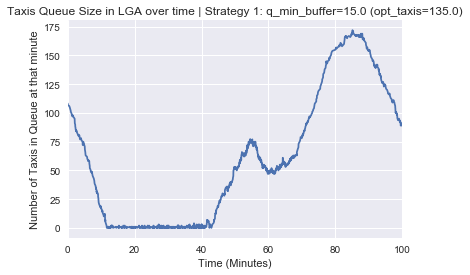

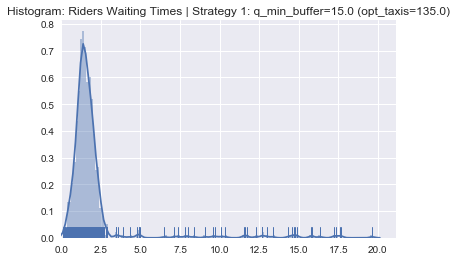

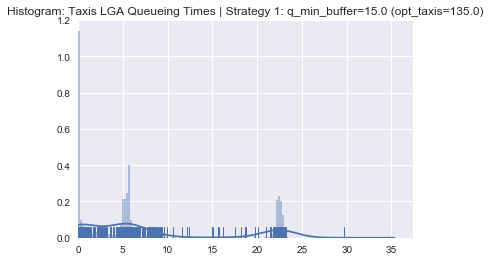


----------SIMULATING STRATEGY 1 WITH BUFFER 16 MIN------------




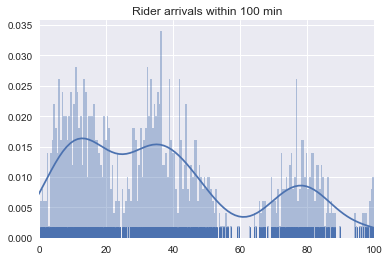

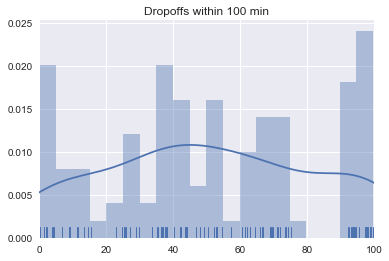

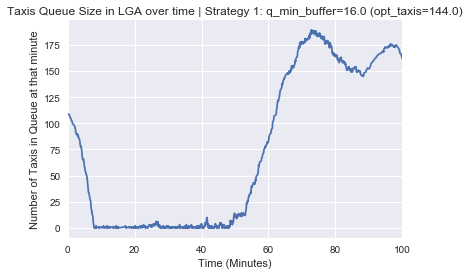

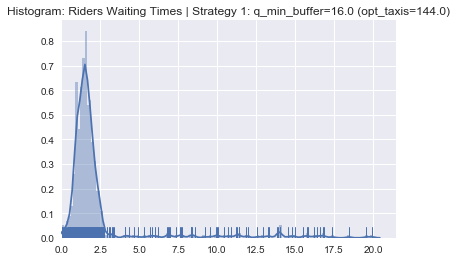

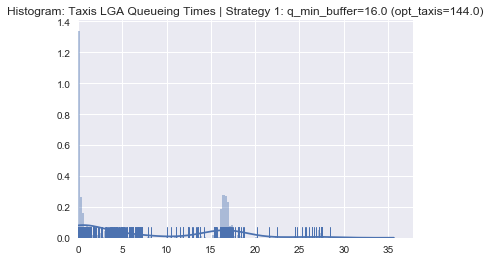


----------SIMULATING STRATEGY 1 WITH BUFFER 17 MIN------------




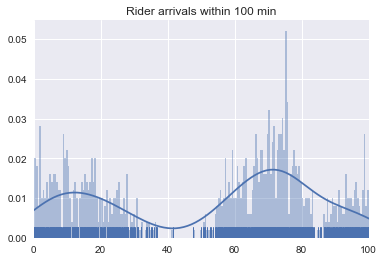

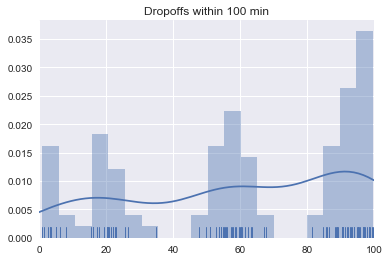

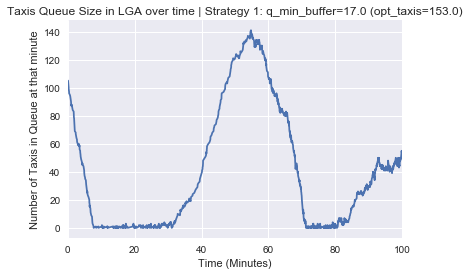

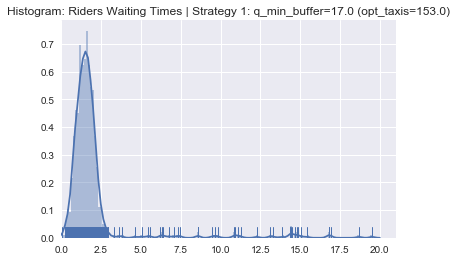

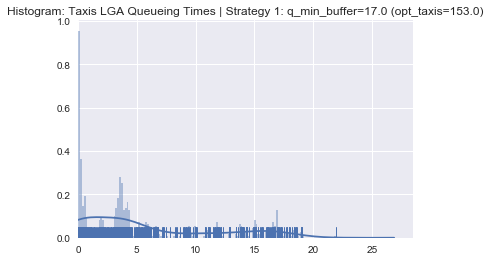


----------SIMULATING STRATEGY 1 WITH BUFFER 18 MIN------------




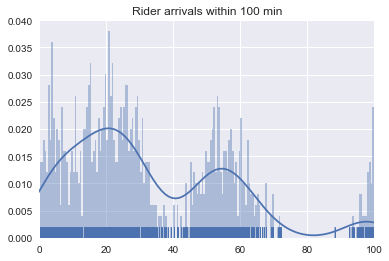

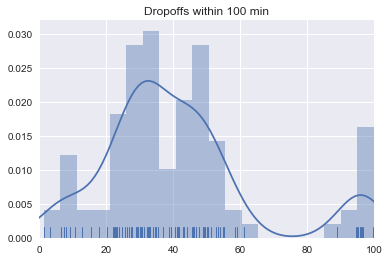

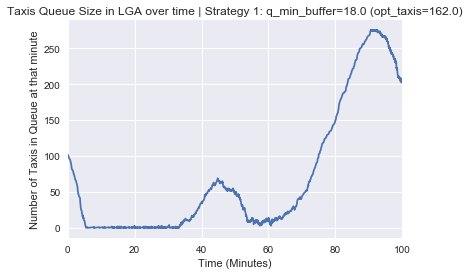

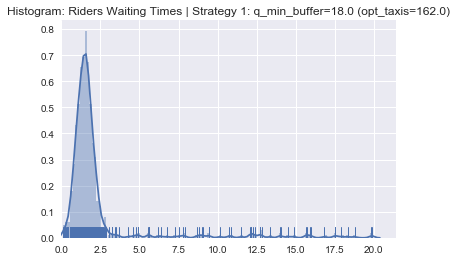

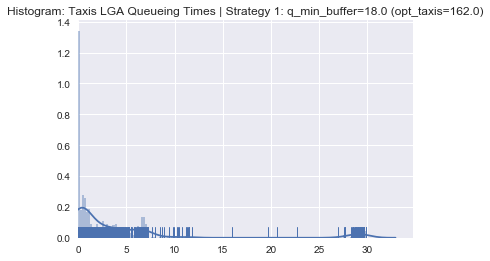


----------SIMULATING STRATEGY 1 WITH BUFFER 19 MIN------------




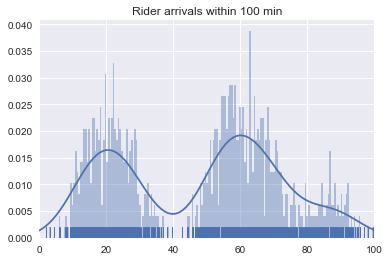

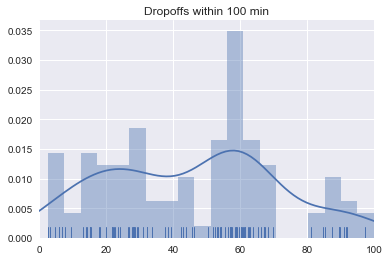

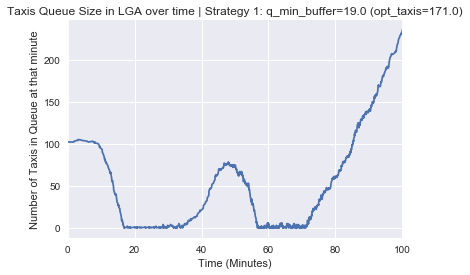

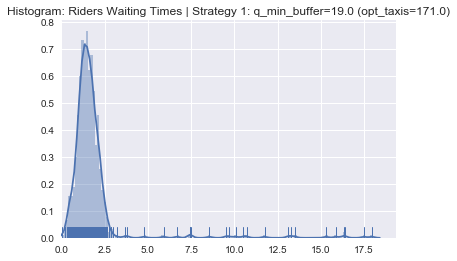

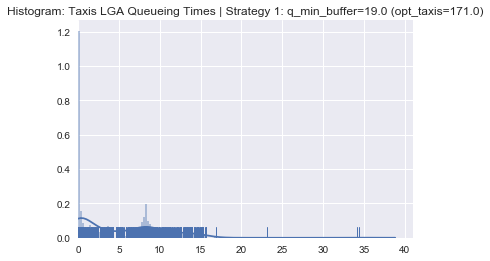

0             0             0  \
strategy                            1.000000      1.000000      1.000000   
s1_queue_min_buffer                 1.000000      1.000000      1.000000   
s1_optimal_taxis_n                  9.000000      9.000000      9.000000   
s1_tolerance                        1.000000      1.000000      1.000000   
s2_rate_coefficient                 1.000000      1.000000      1.000000   
s2_rate                             0.000000      0.000000      0.000000   
time                               99.945612     99.819996     99.919438   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                          336.000000    319.000000    384.000000   
churned                           664.000000    681.000000    616.000000   
LGA_tx_queue_mean                  30.086691     33.620025     27.805919   
LGA_tx_queue_median                 4.922661     22.458552      5.156632   
LGA_tx_queue_std                   34.836993     32.557633     33.161193   
MN_taxis                          386.000000    364.000000    338.000000   
riders_waits_mean                   4.612370      4.845699      3.868144   
riders_waits_median                 1.857592      1.862162      1.649403   
riders_waits_std                    5.110014      5.330609      4.740086   
driver_queueing_mean                1.174440      9.775843      1.244205   
driver_queueing_median              0.400066      0.776014      0.320960   
driver_queueing_std                 1.705101     10.498909      2.248540   
driving_idle_time_total          5216.659684   4095.362989   7409.944575   
driving_to_pickup_time_total     1549.756160   1545.778109   1485.367473   
driving_with_riders_time_total  13127.647749  11876.077983  14802.838551   
costs                            2755.134800   3152.351704   3895.335672   
earnings                        10080.000000   9570.000000  11520.000000   
profit                           7324.865200   6417.648296   7624.664328   
score_cost                      24224.890960  25128.129812  23860.703145   

                                           0             0             0  \
strategy                            1.000000      1.000000      1.000000   
s1_queue_min_buffer                 1.000000      1.000000      1.000000   
s1_optimal_taxis_n                  9.000000      9.000000      9.000000   
s1_tolerance                        1.000000      1.000000      1.000000   
s2_rate_coefficient                 1.000000      1.000000      1.000000   
s2_rate                             0.000000      0.000000      0.000000   
time                               99.880166     99.610464     99.677086   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                          339.000000    324.000000    314.000000   
churned                           661.000000    676.000000    686.000000   
LGA_tx_queue_mean                  30.144004     32.848830     31.256848   
LGA_tx_queue_median                 9.000000     15.569510     13.000000   
LGA_tx_queue_std                   34.271619     34.489749     32.488742   
MN_taxis                          386.000000    377.000000    409.000000   
riders_waits_mean                   4.648098      4.952045      5.492893   
riders_waits_median                 1.869589      2.008985      2.025866   
riders_waits_std                    5.167806      5.237663      5.564633   
driver_queueing_mean                3.011589      6.390034      4.211245   
driver_queuein

In [99]:
#sim = TaxiStand_Controller(n_rider_arrivals=10, n_dropoffs=3, end_time=10)
#sim.run_simulation()
#sim.plots()

n_repetitions = 100
# df = pd.DataFrame()
print("================ Testing Queueing Minutes Buffer For Strategy 1 ===============")
for buffer_min in range(4,20):
    for rep in range(n_repetitions):
        # for each buffer_minutes tested, 
        # repeat same experiment n_repetitions times to reduce uncertainty
        sim = TaxiStand_Controller(n_rider_arrivals=1000, n_dropoffs=100, 
                                   end_time=100,total_taxis=500, 
                                   strategy=1, queue_min_buffer=buffer_min, 
                                   tolerance_proportion = 0.1,
                                   trip_price=30, show=0)
        sim.run_simulation()
        if rep == 1: 
            print("\n----------SIMULATING STRATEGY 1 WITH BUFFER {} MIN------------\n\n".format(buffer_min))
            sim.plots() # present plots only with first iteration
        df = df.append(sim.metrics())

# Backup and Save Results
dfcopy = df
df.to_csv("results_strategy1.csv")
df.T # Show database in a more convenient way: Transformed so that variables are rows instead of columns (for A4)

### Strategy 1 Overall Metrics

number of observations: 2800


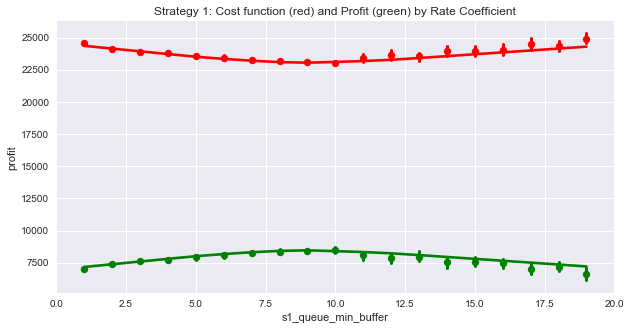

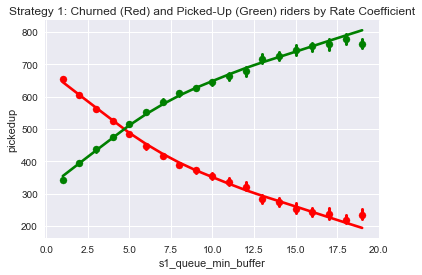

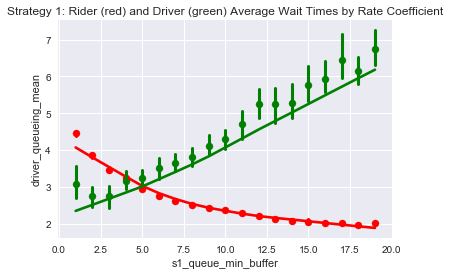

In [105]:
#sns.regplot('obs', 'mod', data=df, lowess=True, ci=95, n_boot=1000)
plt.figure(figsize=(10,5));
print("number of observations: {}".format(len(df)))
sns.regplot(x="s1_queue_min_buffer", y="score_cost", data=df, 
            x_estimator=np.mean, lowess=True, ci=95, n_boot=100, 
            label="Cost Function", color="red").set_title("Strategy 1: Cost Function Score by Rate Coefficient") 
sns.regplot(x="s1_queue_min_buffer", y="profit", data=df, 
            x_estimator=np.mean, lowess=True, ci=95,n_boot=100, 
            label="Profit", color="green").set_title("Strategy 1: Cost function (red) and Profit (green) by Rate Coefficient") 
plt.show();
sns.regplot(x="s1_queue_min_buffer", y="churned", data=df, 
            x_estimator=np.mean, lowess=True, ci=95,n_boot=100, 
            color="red").set_title("Strategy 1: Churned Riders by Rate Coefficient") 
sns.regplot(x="s1_queue_min_buffer", y="pickedup", data=df, 
            x_estimator=np.mean, lowess=True, ci=95,n_boot=100, 
            color="green").set_title("Strategy 1: Churned (Red) and Picked-Up (Green) riders by Rate Coefficient") 
plt.show();
sns.regplot(x="s1_queue_min_buffer", y="riders_waits_mean", data=df, 
            x_estimator=np.mean, lowess=True, ci=95, color = "red",
            n_boot=100).set_title("Strategy 1: Rider Average Wait Times by Rate Coefficient") 
sns.regplot(x="s1_queue_min_buffer", y="driver_queueing_mean", data=df, 
            x_estimator=np.mean, lowess=True, ci=95, color = "green",
            n_boot=100).set_title("Strategy 1: Rider (red) and Driver (green) Average Wait Times by Rate Coefficient") 
plt.show();

### Results from strategy 1: 
Optimal queue waiting minutes buffer was found around 8.00, in this case an optimal queue of 72 Taxis in the queue at any given moment for 1000 riders and 100 random dropoffs over 100 minutes.

# Testing Simulation with Strategy 2
## Constant rate of sending reinforcement taxis to LGA
First, searching values for parameter over a larger span

============Testing rate coefficient of Strategy 2==============




----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 0.75------------






~~~~~~SENDING TAXIS EVERY 0.08 MIN CONSTANTLY FOR 100 MIN~~~~~~





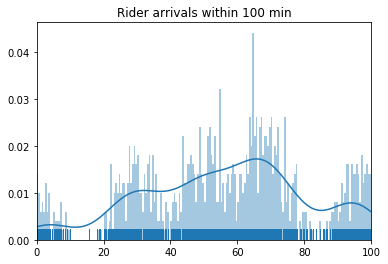

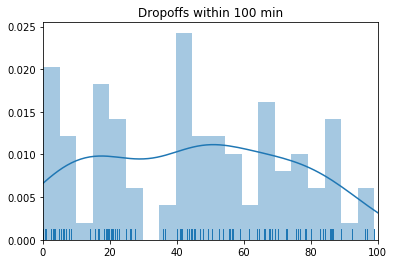

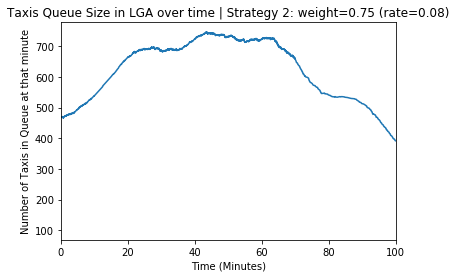

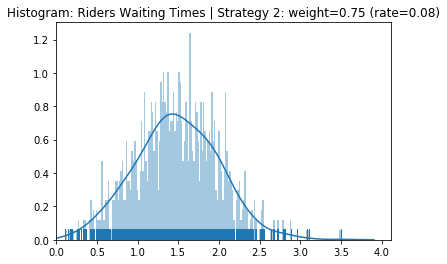

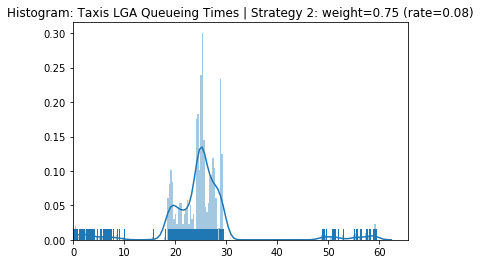





----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 1------------






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~





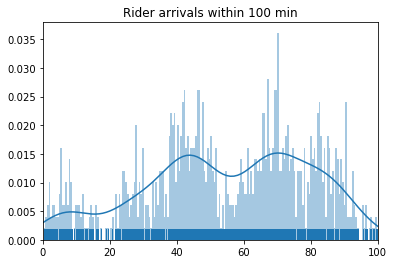

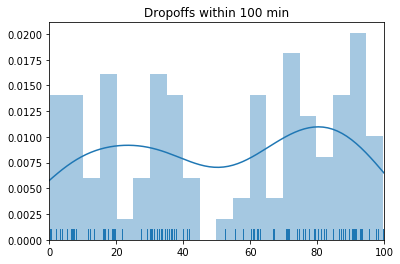

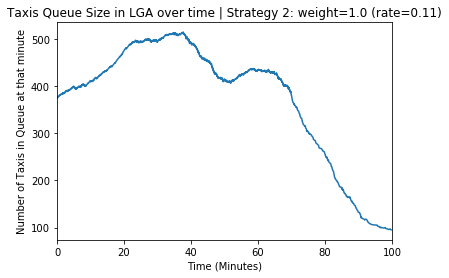

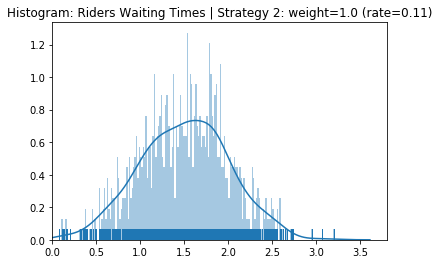

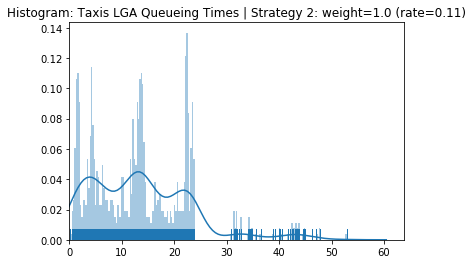





----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 1.25------------






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~





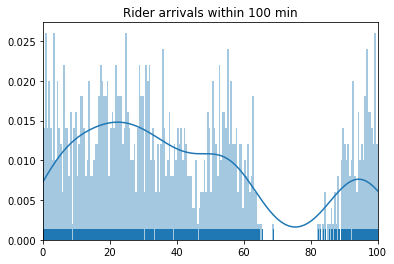

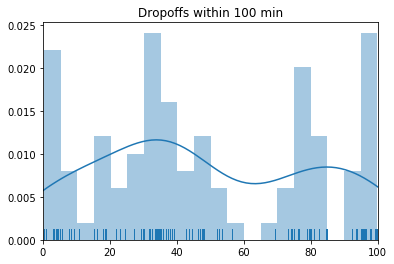

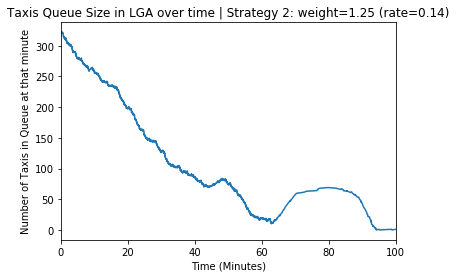

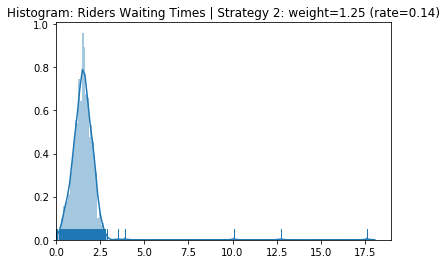

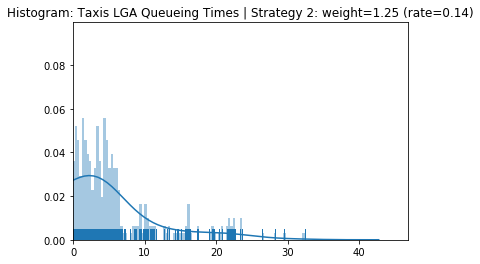





----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 1.5------------






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~





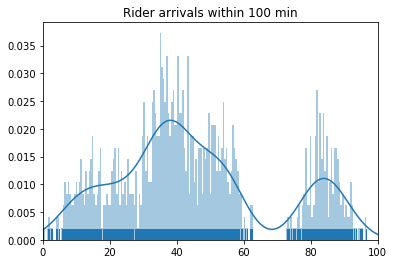

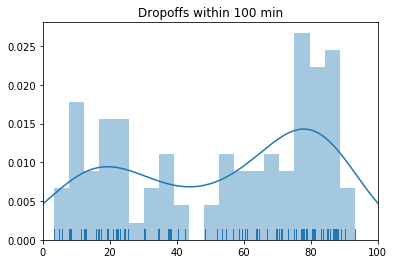

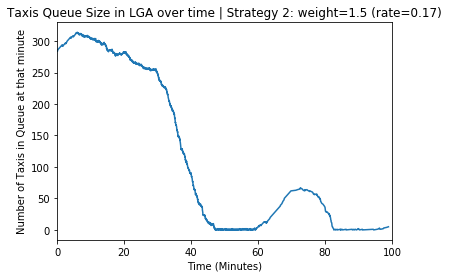

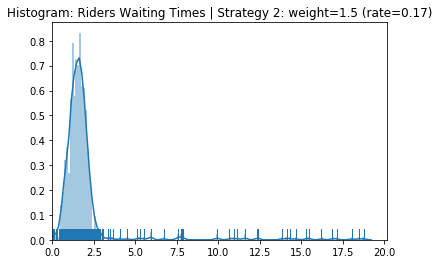

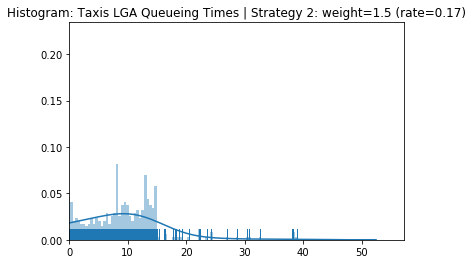





----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 1.75------------






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~





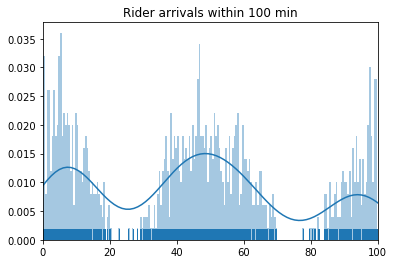

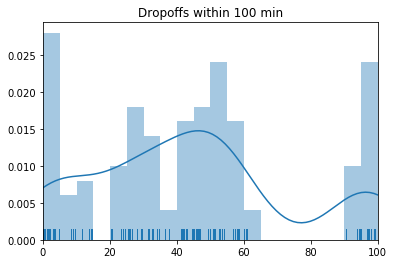

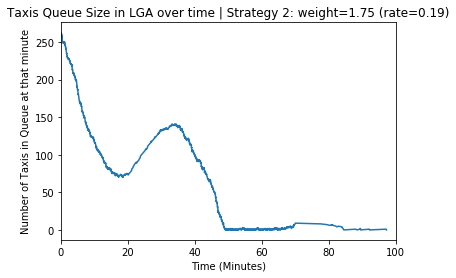

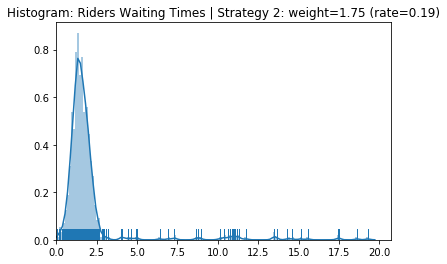

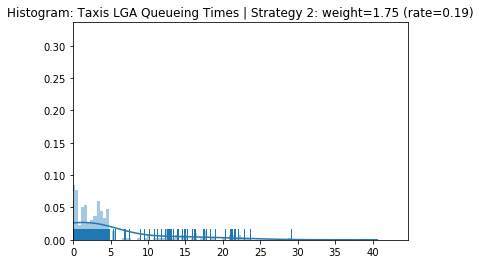





----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 2------------






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~





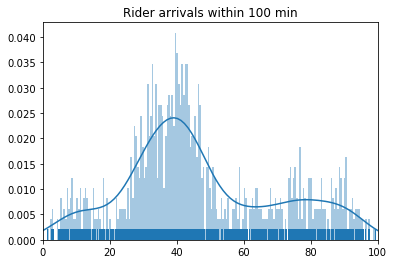

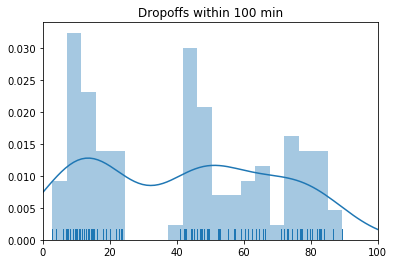

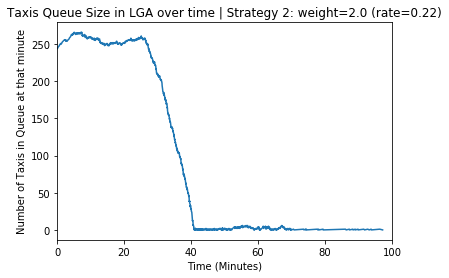

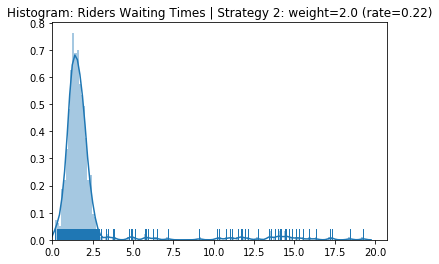

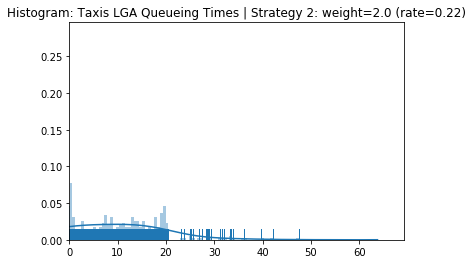





----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 2.25------------






~~~~~~SENDING TAXIS EVERY 0.25 MIN CONSTANTLY FOR 100 MIN~~~~~~





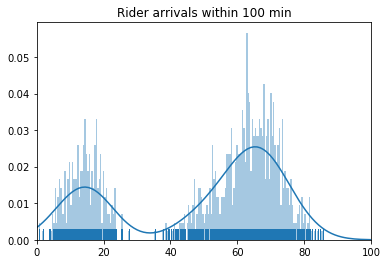

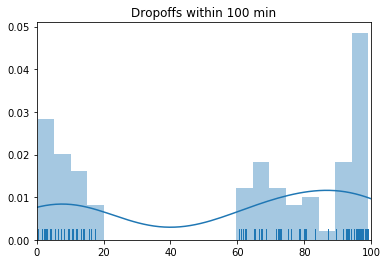

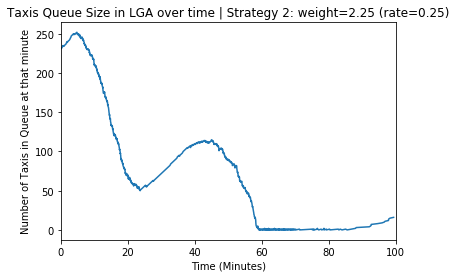

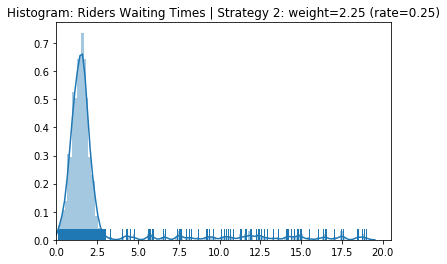

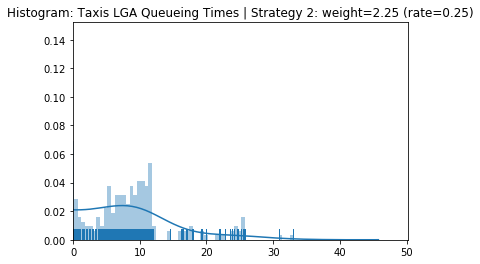





----------SIMULATING STRATEGY 2     WITH RATE COEFFICIENT 2.5------------






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~





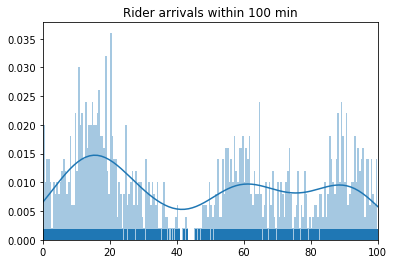

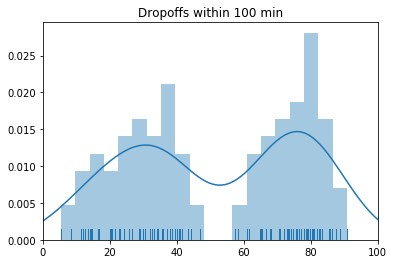

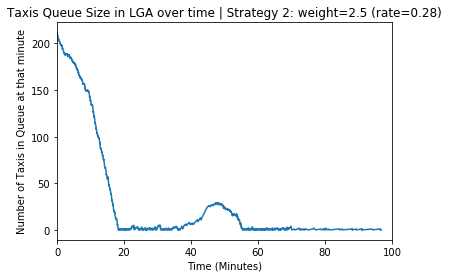

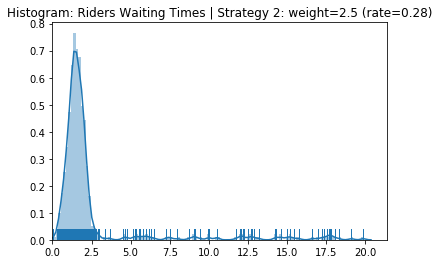

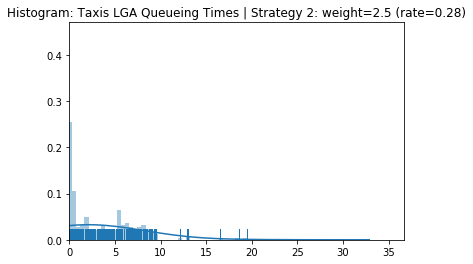

0             0             0  \
strategy                            2.000000      2.000000      2.000000   
s1_queue_min_buffer                 3.000000      3.000000      3.000000   
s1_optimal_taxis_n                  0.000000      0.000000      0.000000   
s1_tolerance                        0.000000      0.000000      0.000000   
s2_rate_coefficient                 0.750000      1.000000      1.250000   
s2_rate                             0.083333      0.111111      0.138889   
time                               99.976262     99.821712     99.990857   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                         1000.000000   1000.000000    918.000000   
churned                             0.000000      0.000000     82.000000   
LGA_tx_queue_mean                 315.605297    210.035172     87.731243   
LGA_tx_queue_median               100.440537     98.100857     55.073830   
LGA_tx_queue_std                  303.465390    190.156273     90.036089   
MN_taxis                          961.000000    963.000000   1086.000000   
riders_waits_mean                   1.482521      1.504773      1.535920   
riders_waits_median                 1.476167      1.526068      1.512391   
riders_waits_std                    0.513661      0.506237      0.877755   
driver_queueing_mean               24.864418     13.446731     -8.398334   
driver_queueing_median             25.074396     13.001735     -8.005950   
driver_queueing_std                 8.691476      9.492136     12.707142   
driving_idle_time_total             0.000000      0.000000      0.000000   
driving_to_pickup_time_total     1482.521023   1504.772962   1409.974877   
driving_with_riders_time_total  33580.404908  33407.159680  31195.887316   
costs                           12432.209173   6723.365708  -3833.839578   
earnings                        30000.000000  30000.000000  27540.000000   
profit                          17567.790827  23276.634292  31373.839578   
score_cost                      13914.730195   8228.138671     36.135299   

                                           0             0             0  \
strategy                            2.000000      2.000000      2.000000   
s1_queue_min_buffer                 3.000000      3.000000      3.000000   
s1_optimal_taxis_n                  0.000000      0.000000      0.000000   
s1_tolerance                        0.000000      0.000000      0.000000   
s2_rate_coefficient                 1.500000      1.750000      2.000000   
s2_rate                             0.166667      0.194444      0.222222   
time                               99.969830     99.925001     99.544750   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                          830.000000    756.000000    705.000000   
churned                           170.000000    244.000000    295.000000   
LGA_tx_queue_mean                  91.699128     64.255579     79.326637   
LGA_tx_queue_median                44.597208     46.124962     39.457155   
LGA_tx_queue_std                  101.882165     67.903517     90.291564   
MN_taxis                          963.000000    910.000000    858.000000   
riders_waits_mean                   1.915880      1.969384      2.163034   
riders_waits_median                 1.556397      1.507862      1.527144   
riders_waits_std                    2.151352      2.276015      2.759707   
driver_queueing_mean               -4.763421    -10.382419     -3.848728   
driver_queuein

In [4]:
#sim = TaxiStand_Controller(n_rider_arrivals=10, n_dropoffs=3, end_time=10)
#sim.run_simulation()
#sim.plots()

df2 = pd.DataFrame()
print("============Testing rate coefficient of Strategy 2==============")
for weight in [0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]:
    sim = TaxiStand_Controller(n_rider_arrivals=1000, n_dropoffs=100, 
                               end_time=100,total_taxis=500,
                               strategy=2, # TESTING STRATEGY 2 
                               rate_coefficient = weight, # TESTING RATE COEFFICIENT 
                               trip_price=30, show=0)
    print("\n\n----------SIMULATING STRATEGY 2 \
    WITH RATE COEFFICIENT {}------------\n\n".format(weight))
    sim.run_simulation()
    sim.plots()
    row = sim.metrics()
    df = df.append(sim.metrics())

dfcopy2 = df2
df2.to_csv("results_strategy2A.csv")
df2.T

#### Second, refining values

============Testing rate coefficient of Strategy 2==============



~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~





----------SIMULATING STRATEGY 2 WITH RATE COEFFICIENT 0.8------------




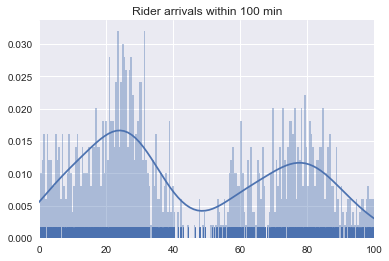

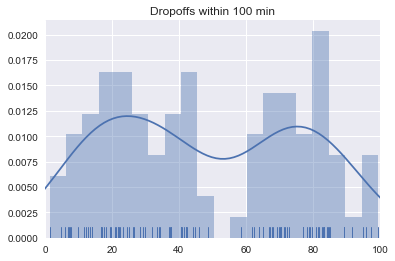

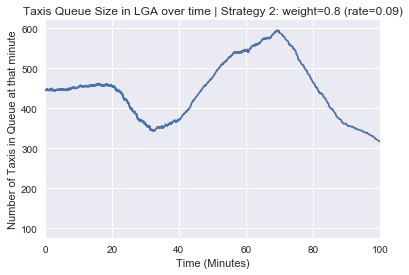

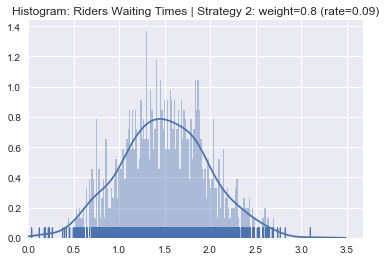

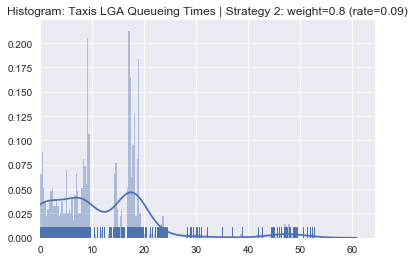




~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.09 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

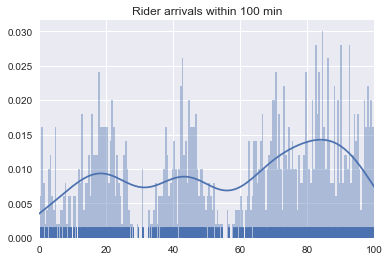

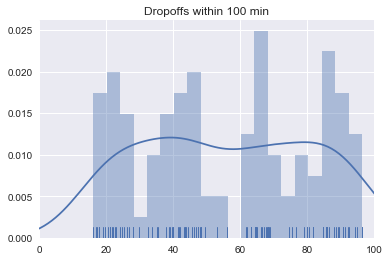

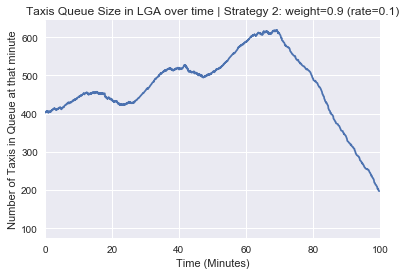

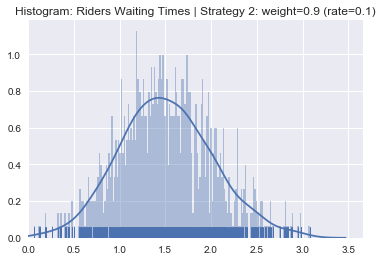

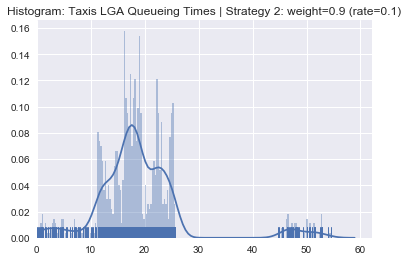




~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.1 M

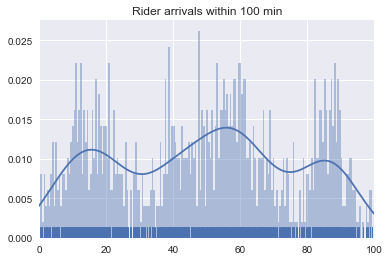

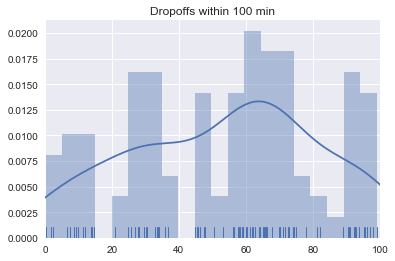

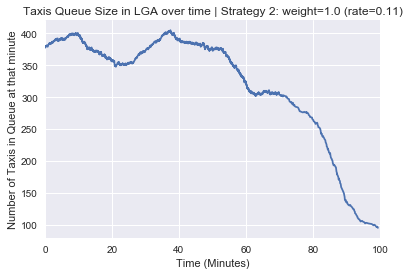

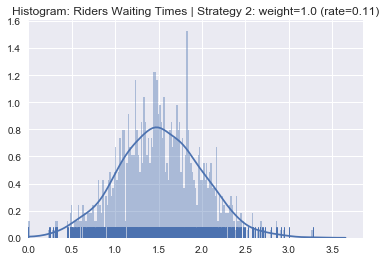

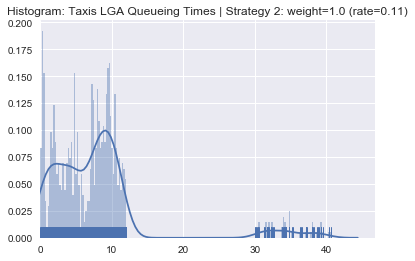




~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.11 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

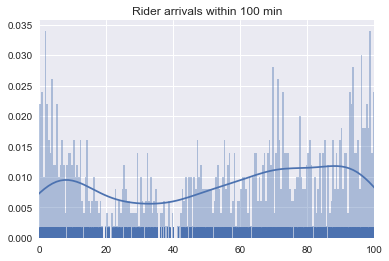

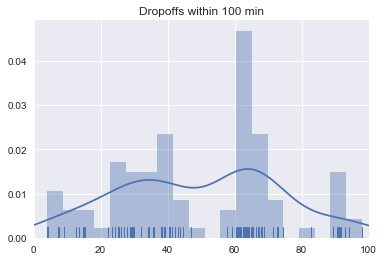

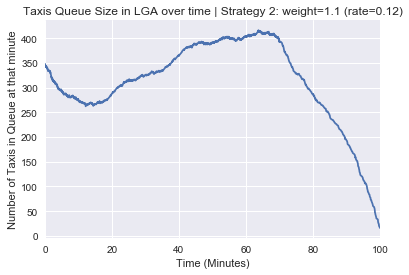

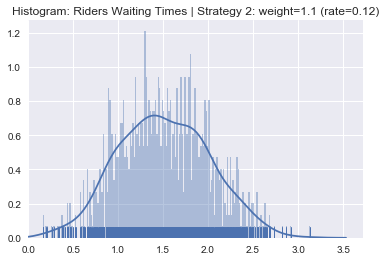

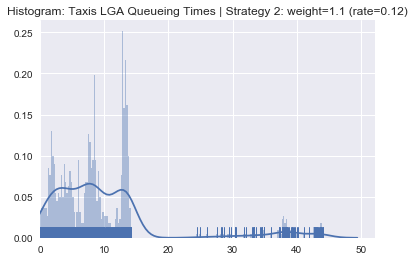




~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.12 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

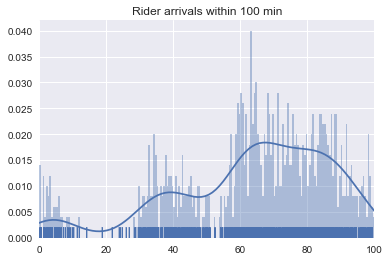

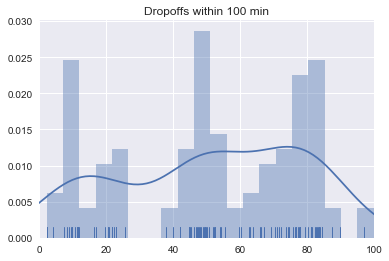

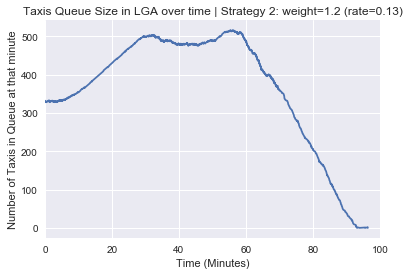

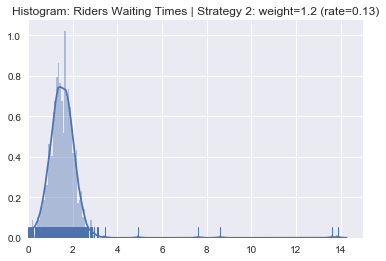

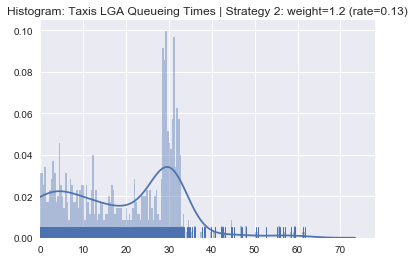




~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.13 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

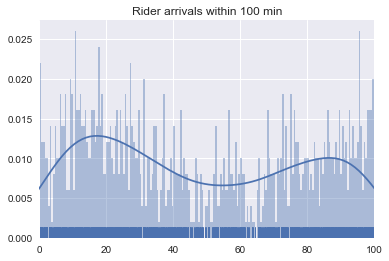

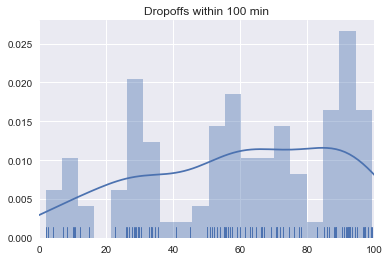

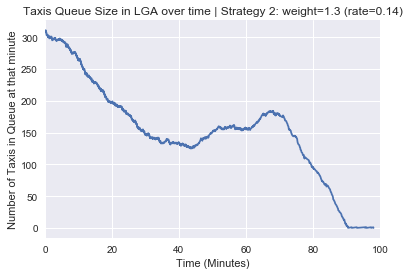

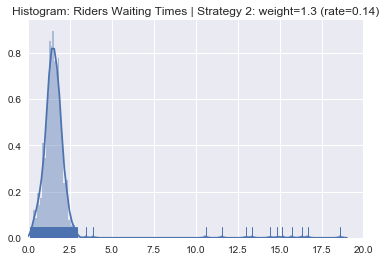

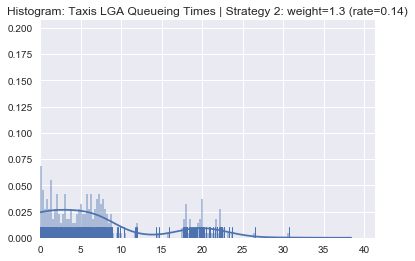




~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.14 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

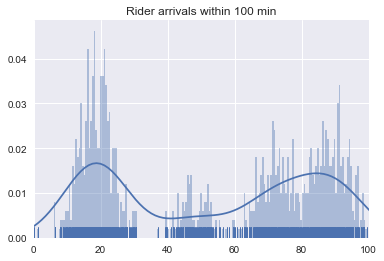

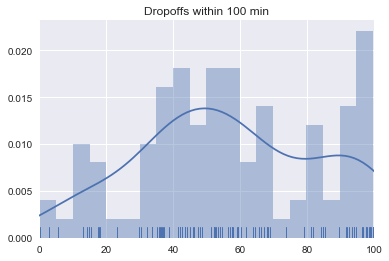

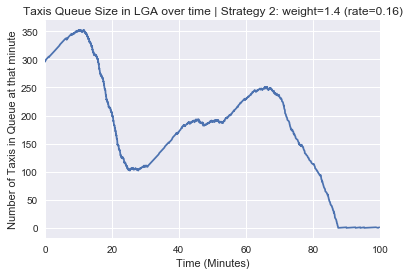

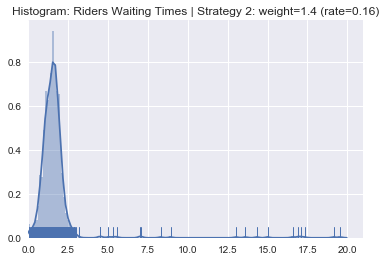

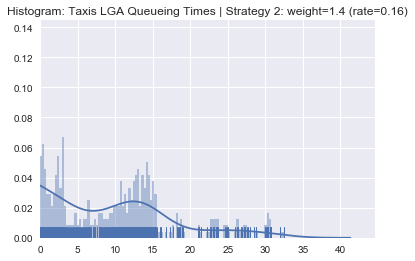




~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.16 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

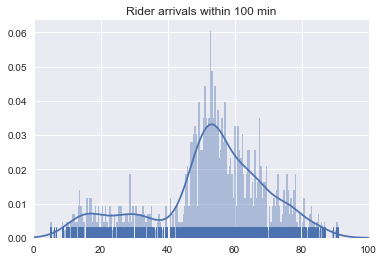

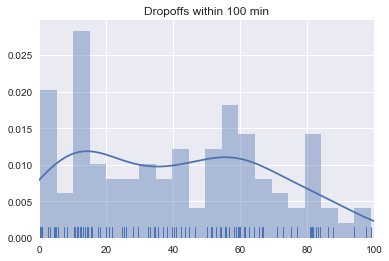

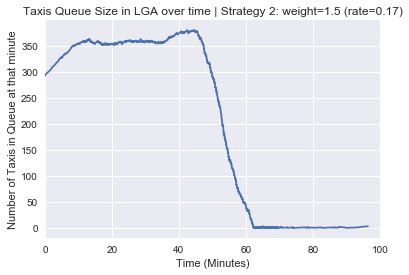

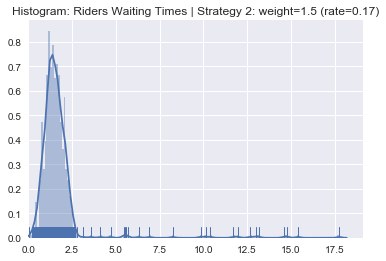

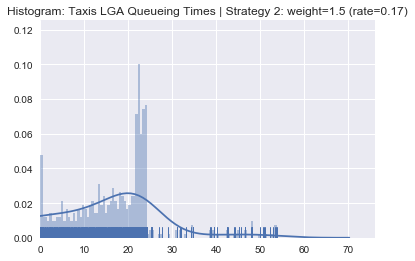




~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.17 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

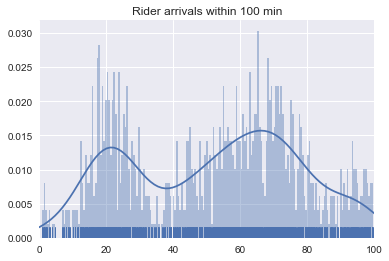

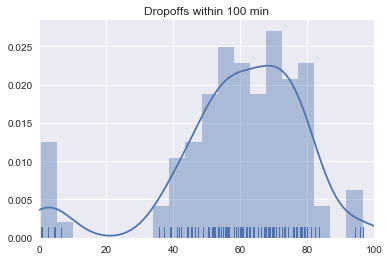

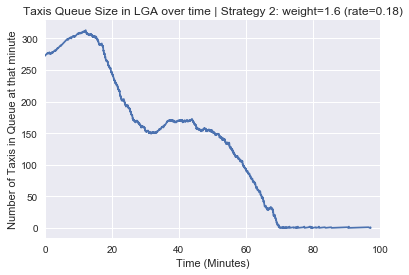

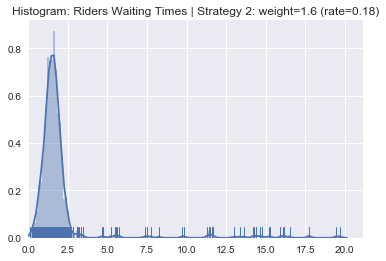

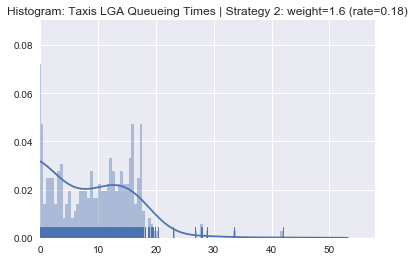




~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.18 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

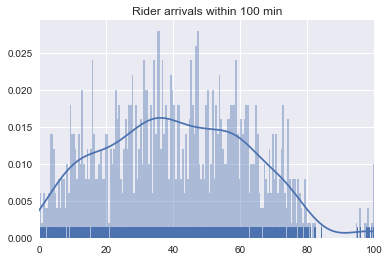

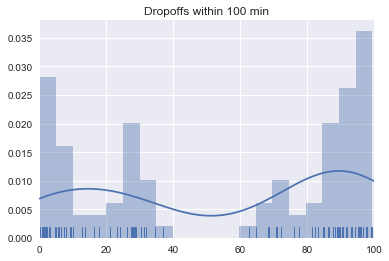

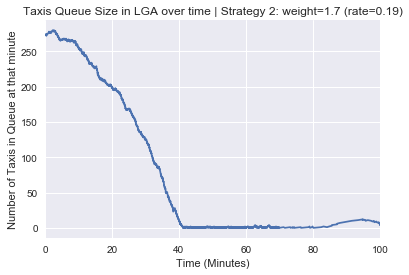

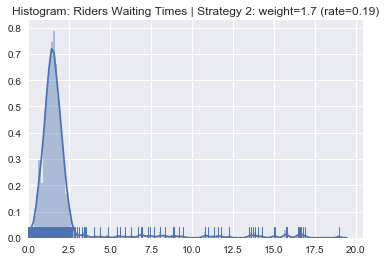

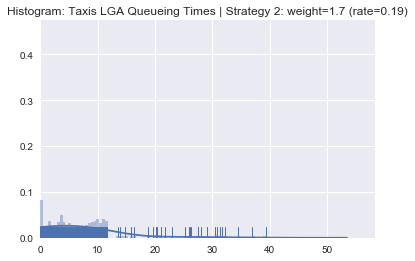




~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.19 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

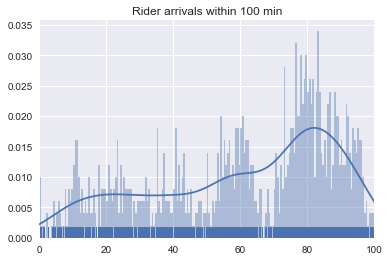

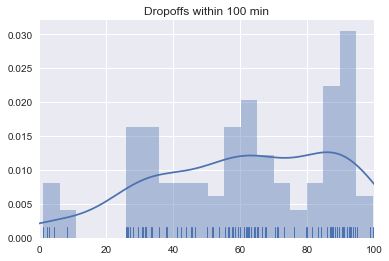

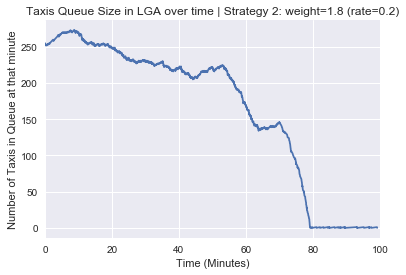

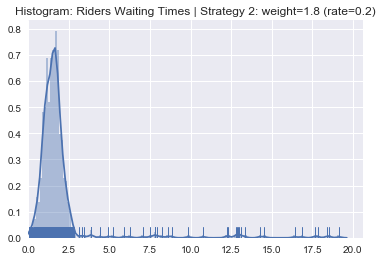

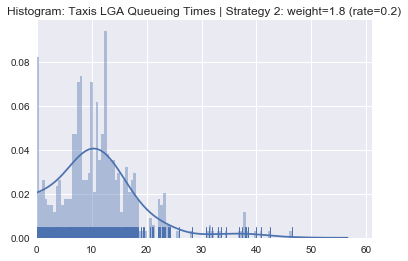




~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.2 M

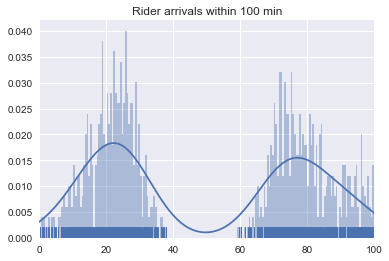

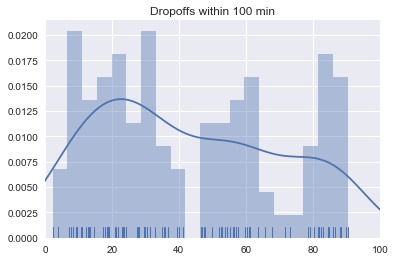

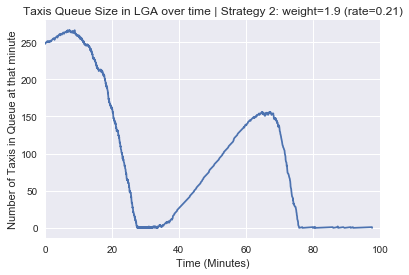

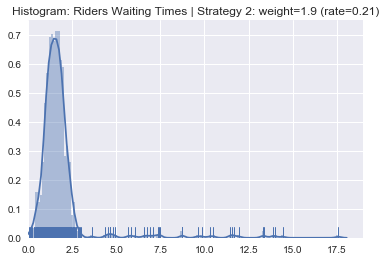

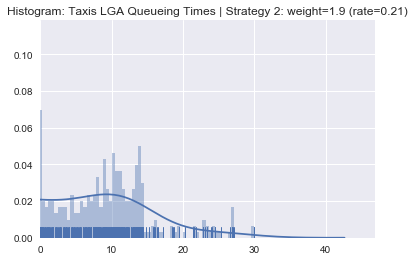




~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.21 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

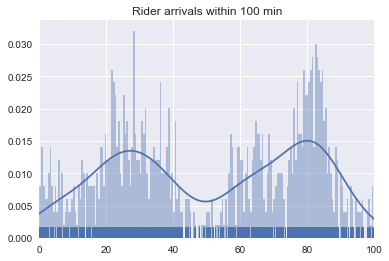

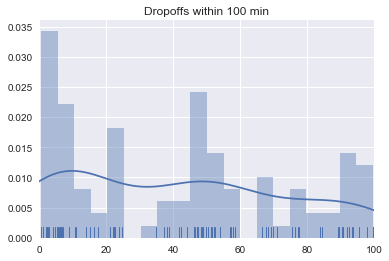

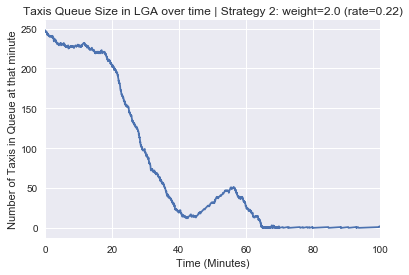

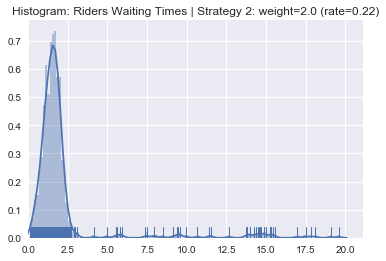

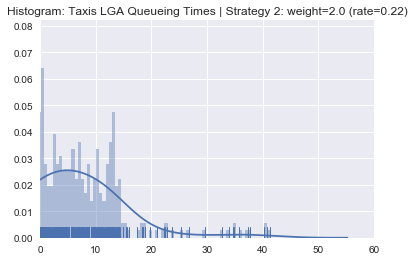




~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.22 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

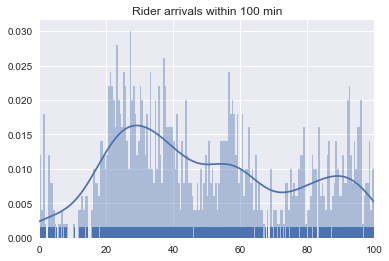

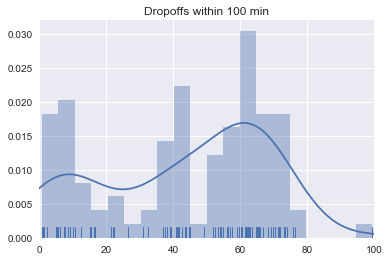

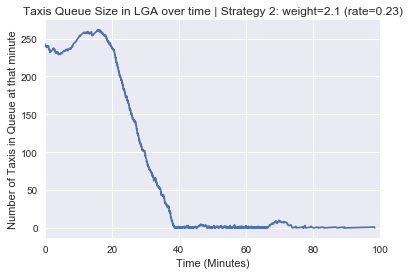

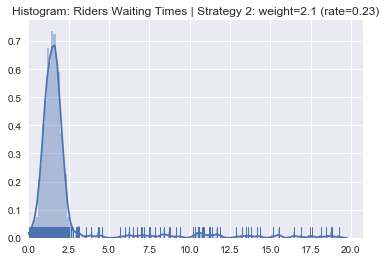

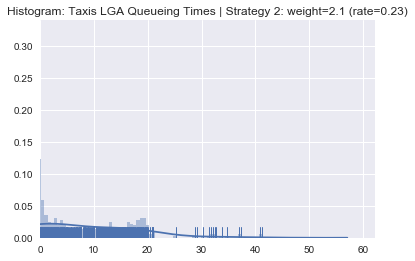




~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.23 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

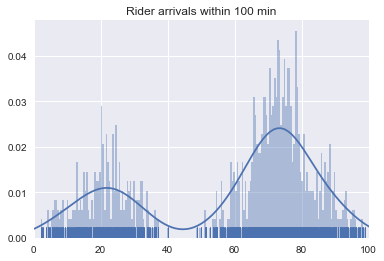

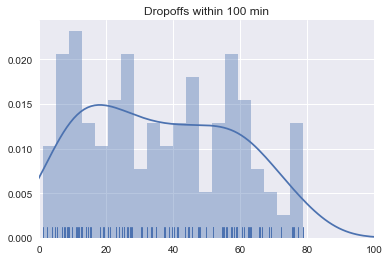

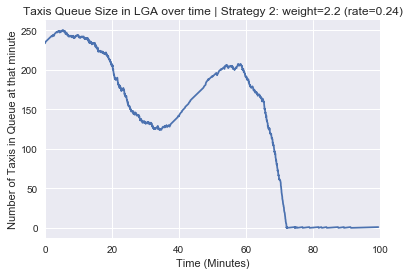

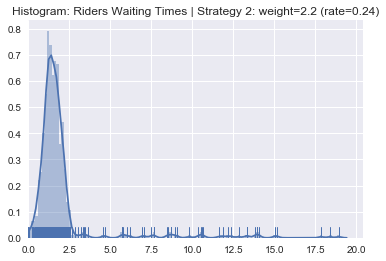

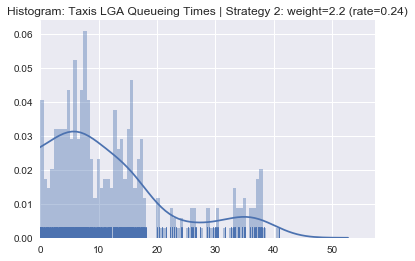




~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.24 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

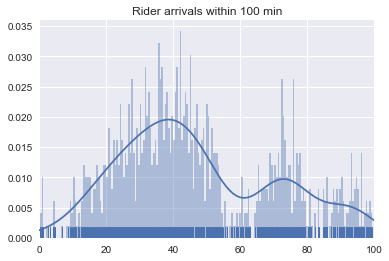

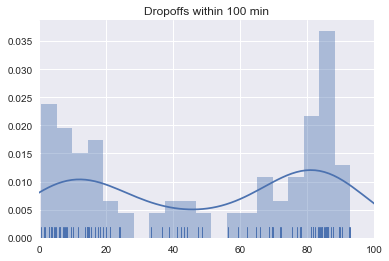

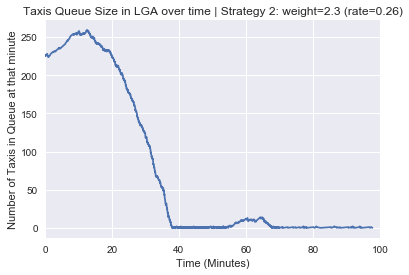

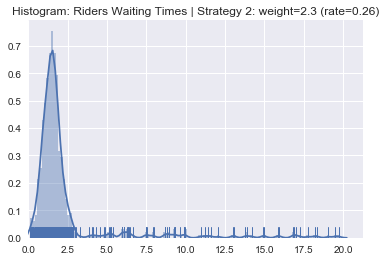

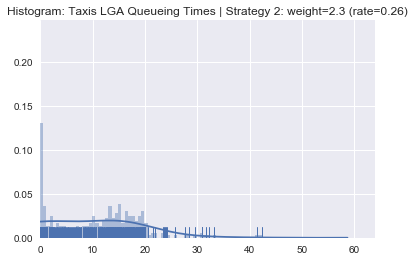




~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.26 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

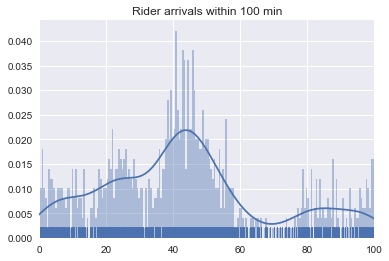

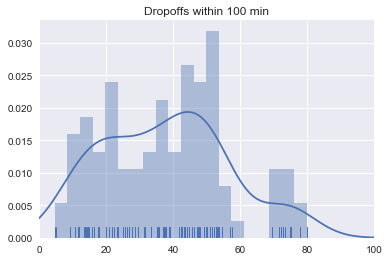

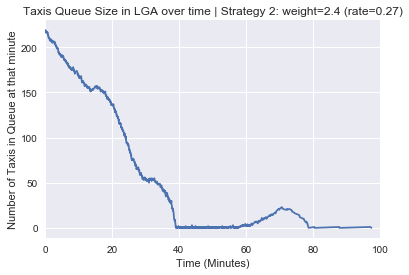

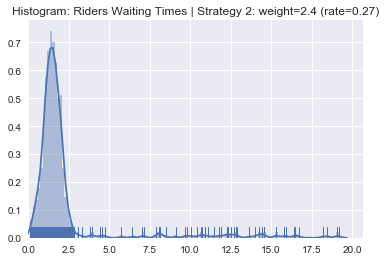

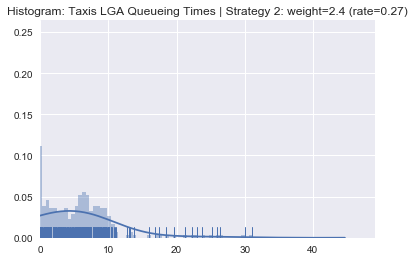




~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.27 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

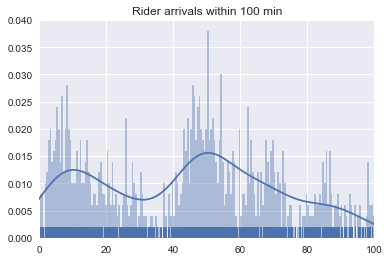

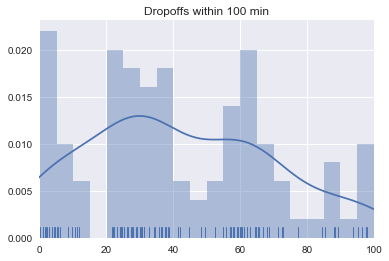

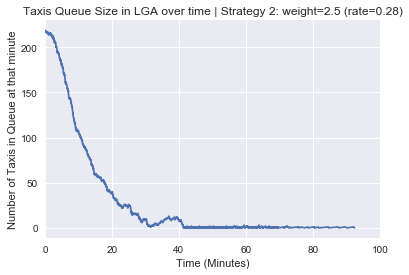

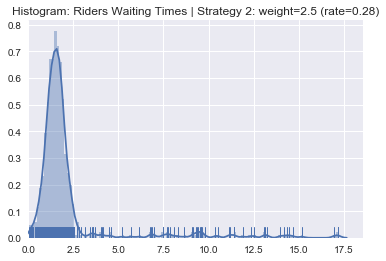

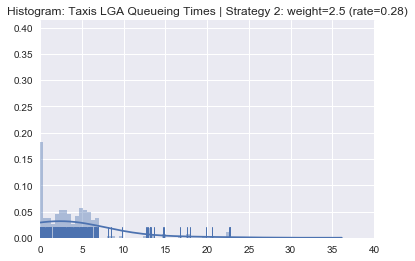




~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.28 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

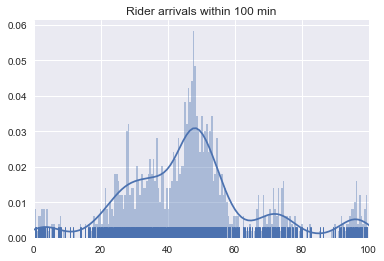

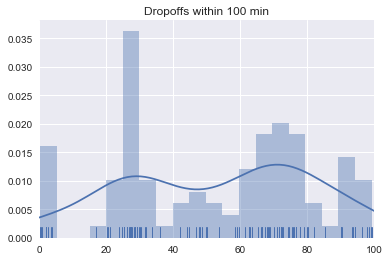

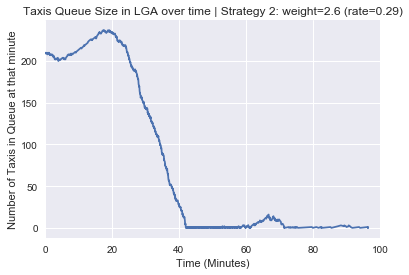

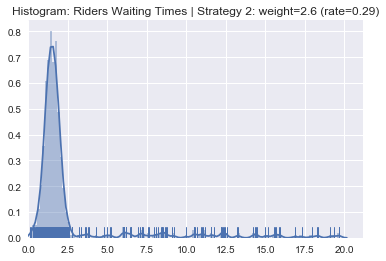

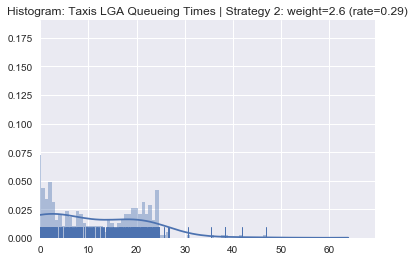




~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.29 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

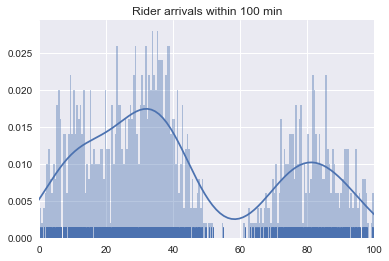

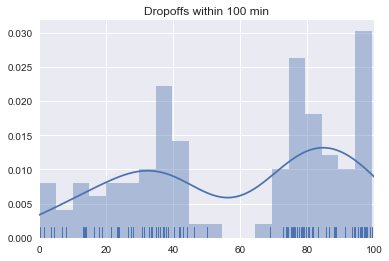

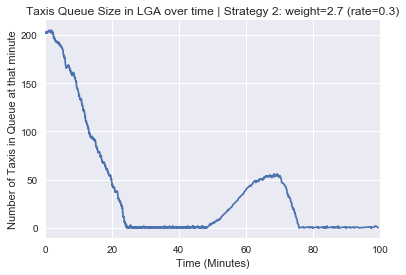

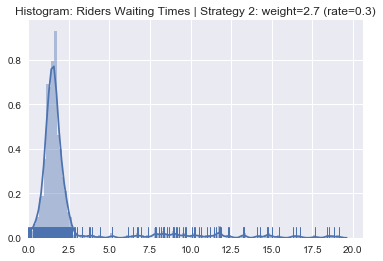

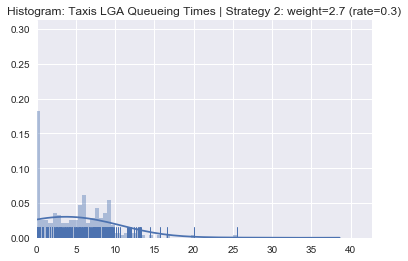




~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.3 M

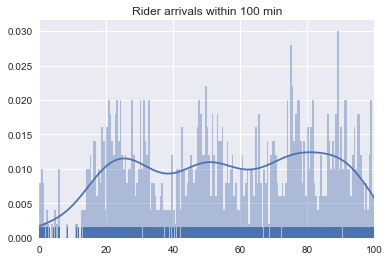

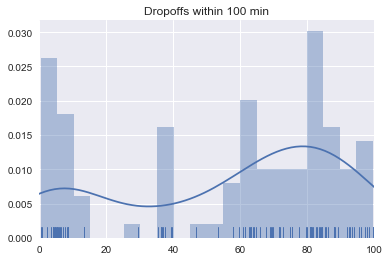

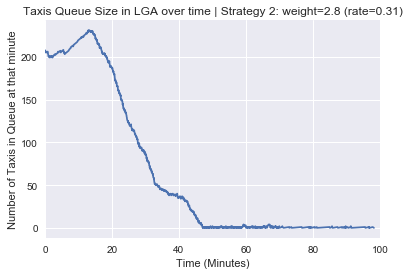

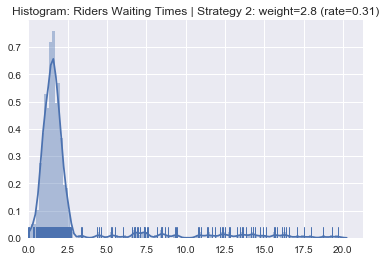

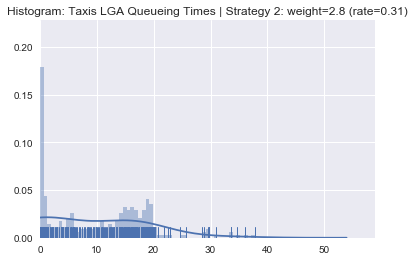




~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.31 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

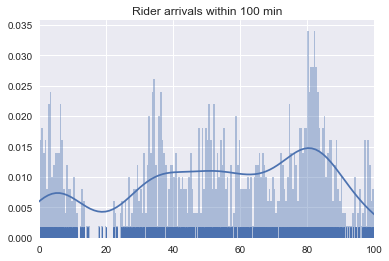

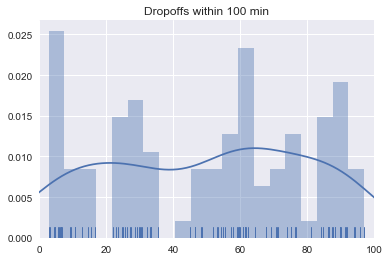

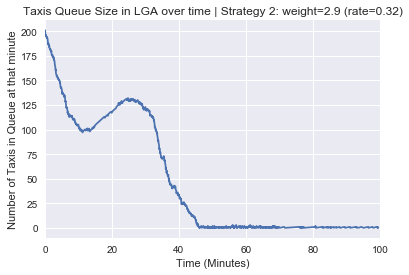

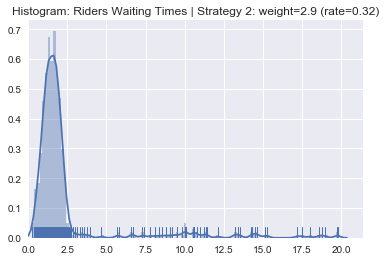

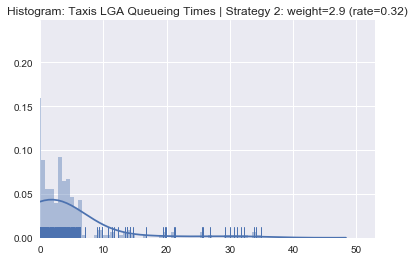




~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAXIS EVERY 0.32 MIN CONSTANTLY FOR 100 MIN~~~~~~






~~~~~~SENDING TAX

0             0             0  \
strategy                            2.000000      2.000000      2.000000   
s1_queue_min_buffer                 3.000000      3.000000      3.000000   
s1_optimal_taxis_n                  0.000000      0.000000      0.000000   
s1_tolerance                        0.000000      0.000000      0.000000   
s2_rate_coefficient                 0.750000      1.000000      1.250000   
s2_rate                             0.083333      0.111111      0.138889   
time                               99.976262     99.821712     99.990857   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                         1000.000000   1000.000000    918.000000   
churned                             0.000000      0.000000     82.000000   
LGA_tx_queue_mean                 315.605297    210.035172     87.731243   
LGA_tx_queue_median               100.440537     98.100857     55.073830   
LGA_tx_queue_std                  303.465390    190.156273     90.036089   
MN_taxis                          961.000000    963.000000   1086.000000   
riders_waits_mean                   1.482521      1.504773      1.535920   
riders_waits_median                 1.476167      1.526068      1.512391   
riders_waits_std                    0.513661      0.506237      0.877755   
driver_queueing_mean               24.864418     13.446731     -8.398334   
driver_queueing_median             25.074396     13.001735     -8.005950   
driver_queueing_std                 8.691476      9.492136     12.707142   
driving_idle_time_total             0.000000      0.000000      0.000000   
driving_to_pickup_time_total     1482.521023   1504.772962   1409.974877   
driving_with_riders_time_total  33580.404908  33407.159680  31195.887316   
costs                           12432.209173   6723.365708  -3833.839578   
earnings                        30000.000000  30000.000000  27540.000000   
profit                          17567.790827  23276.634292  31373.839578   
score_cost                      13914.730195   8228.138671     36.135299   

                                           0             0             0  \
strategy                            2.000000      2.000000      2.000000   
s1_queue_min_buffer                 3.000000      3.000000      3.000000   
s1_optimal_taxis_n                  0.000000      0.000000      0.000000   
s1_tolerance                        0.000000      0.000000      0.000000   
s2_rate_coefficient                 1.500000      1.750000      2.000000   
s2_rate                             0.166667      0.194444      0.222222   
time                               99.969830     99.925001     99.544750   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                          830.000000    756.000000    705.000000   
churned                           170.000000    244.000000    295.000000   
LGA_tx_queue_mean                  91.699128     64.255579     79.326637   
LGA_tx_queue_median                44.597208     46.124962     39.457155   
LGA_tx_queue_std                  101.882165     67.903517     90.291564   
MN_taxis                          963.000000    910.000000    858.000000   
riders_waits_mean                   1.915880      1.969384      2.163034   
riders_waits_median                 1.556397      1.507862      1.527144   
riders_waits_std                    2.151352      2.276015      2.759707   
driver_queueing_mean               -4.763421    -10.382419     -3.848728   
driver_queuein

In [73]:
# REFINING VALUES
# Continuing the same DF2 , not creating a new one
print("============Testing rate coefficient of Strategy 2==============")
n_repeats = 100
for weight in np.arange(0.8,3,0.1):
    for i in range(n_repeats):
        sim = TaxiStand_Controller(n_rider_arrivals=1000, n_dropoffs=100, 
                                   end_time=100,total_taxis=500,
                                   strategy=2, # TESTING STRATEGY 2 
                                   rate_coefficient = weight, # TESTING RATE COEFFICIENT 
                                   trip_price=30, show=0)
        sim.run_simulation()
        if i == 0: #show only first time for each parameter tested, not every repitition
            print("\n\n----------SIMULATING STRATEGY 2 WITH RATE COEFFICIENT {}------------\n\n".format(weight))
            sim.plots() 
        df2 = df2.append(sim.metrics())


# Backup and Save Results
dfcopy2 = df2
df2.to_csv("results_strategy2B.csv")
df2.T # Show database in a more convenient way: Transformed so that variables are rows instead of columns (for A4)

### Results from Strategy 2: 
The Best rate coefficient was 1.2.
We can test more closely around the range of 1 - 2.
Below a coefficient of 1 there was an excess of taxis (obviously from the formula). This was included just to proof-test and show trend.

In [37]:
df2.head(10).T
df2

0             0             0  \
strategy                            2.000000      2.000000      2.000000   
s1_queue_min_buffer                 3.000000      3.000000      3.000000   
s1_optimal_taxis_n                  0.000000      0.000000      0.000000   
s1_tolerance                        0.000000      0.000000      0.000000   
s2_rate_coefficient                 0.750000      1.000000      1.250000   
s2_rate                             0.083333      0.111111      0.138889   
time                               99.976262     99.821712     99.990857   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                         1000.000000   1000.000000    918.000000   
churned                             0.000000      0.000000     82.000000   
LGA_tx_queue_mean                 315.605297    210.035172     87.731243   
LGA_tx_queue_median               100.440537     98.100857     55.073830   
LGA_tx_queue_std                  303.465390    190.156273     90.036089   
MN_taxis                          961.000000    963.000000   1086.000000   
riders_waits_mean                   1.482521      1.504773      1.535920   
riders_waits_median                 1.476167      1.526068      1.512391   
riders_waits_std                    0.513661      0.506237      0.877755   
driver_queueing_mean               24.864418     13.446731     -8.398334   
driver_queueing_median             25.074396     13.001735     -8.005950   
driver_queueing_std                 8.691476      9.492136     12.707142   
driving_idle_time_total             0.000000      0.000000      0.000000   
driving_to_pickup_time_total     1482.521023   1504.772962   1409.974877   
driving_with_riders_time_total  33580.404908  33407.159680  31195.887316   
costs                           12432.209173   6723.365708  -3833.839578   
earnings                        30000.000000  30000.000000  27540.000000   
profit                          17567.790827  23276.634292  31373.839578   
score_cost                      13914.730195   8228.138671     36.135299   

                                           0             0             0  \
strategy                            2.000000      2.000000      2.000000   
s1_queue_min_buffer                 3.000000      3.000000      3.000000   
s1_optimal_taxis_n                  0.000000      0.000000      0.000000   
s1_tolerance                        0.000000      0.000000      0.000000   
s2_rate_coefficient                 1.500000      1.750000      2.000000   
s2_rate                             0.166667      0.194444      0.222222   
time                               99.969830     99.925001     99.544750   
riders_initialized               1000.000000   1000.000000   1000.000000   
riders_so_far                    1000.000000   1000.000000   1000.000000   
dropoffs_initialized              100.000000    100.000000    100.000000   
dropoffs_LGA_occured              100.000000    100.000000    100.000000   
pickedup                          830.000000    756.000000    705.000000   
churned                           170.000000    244.000000    295.000000   
LGA_tx_queue_mean                  91.699128     64.255579     79.326637   
LGA_tx_queue_median                44.597208     46.124962     39.457155   
LGA_tx_queue_std                  101.882165     67.903517     90.291564   
MN_taxis                          963.000000    910.000000    858.000000   
riders_waits_mean                   1.915880      1.969384      2.163034   
riders_waits_median                 1.556397      1.507862      1.527144   
riders_waits_std                    2.151352      2.276015      2.759707   
driver_queueing_mean               -4.763421    -10.382419     -3.848728   
driver_queuein

In [92]:
# df2 = df2[df2.s2_rate_coefficient != 1.25] # there were outliers due to manual variations in other parameters, I here removed those 4 outliers
# df2 = df2[12:] removed initial outliers

## Strategy 2 Overall Metrics

number of observations: 2940


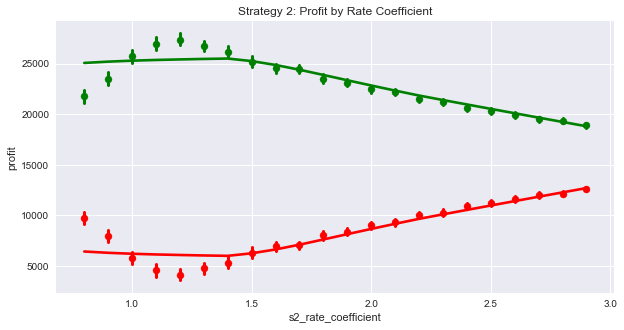

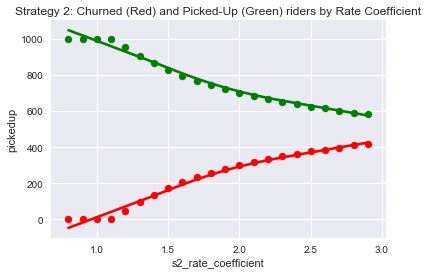

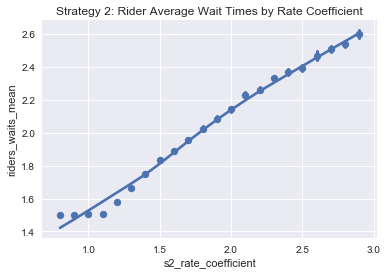

In [93]:
#sns.regplot('obs', 'mod', data=df2, lowess=True, ci=95, n_boot=1000)
plt.figure(figsize=(10,5))
print("number of observations: {}".format(len(df2)))
sns.regplot(x="s2_rate_coefficient", y="score_cost", data=df2, 
            x_estimator=np.mean, lowess=True, ci=95, #n_boot=100, 
            label="Cost Function", color="red").set_title("Strategy 2: Cost Function Score by Rate Coefficient") 
sns.regplot(x="s2_rate_coefficient", y="profit", data=df2, 
            x_estimator=np.mean, lowess=True, ci=95,#n_boot=100, 
            label="Profit", color="green").set_title("Strategy 2: Profit by Rate Coefficient") 
plt.show();
sns.regplot(x="s2_rate_coefficient", y="churned", data=df2, 
            x_estimator=np.mean, lowess=True, ci=95,#n_boot=100, 
            color="red").set_title("Strategy 2: Churned Riders by Rate Coefficient") 
sns.regplot(x="s2_rate_coefficient", y="pickedup", data=df2, 
            x_estimator=np.mean, lowess=True, ci=95,#n_boot=100, 
            color="green").set_title("Strategy 2: Churned (Red) and Picked-Up (Green) riders by Rate Coefficient") 
plt.show();
sns.regplot(x="s2_rate_coefficient", y="riders_waits_mean", data=df2, 
            x_estimator=np.mean, lowess=True, ci=95,
            n_boot=100).set_title("Strategy 2: Rider Average Wait Times by Rate Coefficient") 
plt.show();

In [108]:
df2[df2.s2_rate_coefficient>1.2]

strategy  s1_queue_min_buffer  s1_optimal_taxis_n  s1_tolerance  \
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
..       ...                  ...                 ...           ...   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                  3.0                 0.0           0.0   
0        2.0                